In [1]:
import pandas as pd
import yfinance as yf
from tqdm import tqdm


esg_csv = "../data/raw/sp500_esg_ceo_info-filtered.csv"  
esg_df = pd.read_csv(esg_csv)

print("Columnas CSV ESG:", esg_df.columns)
print("Número de tickers en CSV:", esg_df["Ticker"].nunique())

Columnas CSV ESG: Index(['Ticker', 'ESG Score', 'Governance Score', 'Environment Score',
       'Social Score', 'ESG Score Date', 'ESG Status', 'CEO Full Name',
       'CEO Gender', 'CEO Status', 'Year'],
      dtype='object')
Número de tickers en CSV: 426


In [2]:
# Selección de únicamente 50 tickers del CSV sp500_esg_ceo_info-filtered

tickers = esg_df["Ticker"].dropna().unique().tolist()[:50]

start_date = "2018-01-01"
end_date = "2025-08-30"

all_data = []


In [3]:
batch_size = 50
for i in range(0, len(tickers), batch_size):
    batch = tickers[i:i+batch_size]
    print(f"\nDescargando batch {i//batch_size + 1} de {len(tickers)//batch_size + 1}...")
    
    try:
        df = yf.download(
            batch,
            start=start_date,
            end=end_date,
            progress=False,
            auto_adjust=False  # 
        )
        
        # Pasamos de columnas multi-índice a columnas simples
        df = df.stack(level=1).reset_index()
        df.rename(columns={"level_1": "Ticker"}, inplace=True)
        
        all_data.append(df)
    except Exception as e:
        print(f"Error en batch {i//batch_size + 1}: {e}")



Descargando batch 1 de 2...



1 Failed download:
['ANSS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2018-01-01 -> 2025-08-30) (Yahoo error = "No data found, symbol may be delisted")')


In [4]:
# Unimos todos los datos financieros
fin_df = pd.concat(all_data, ignore_index=True)

print(f"\nDatos financieros: {fin_df.shape}")


Datos financieros: (94374, 8)


In [5]:
# Unimos con ESG (por ticker)
dataset_final = pd.merge(fin_df, esg_df, on="Ticker", how="inner")

In [6]:
# Creamos features de volatilidad para obtener 2 posibles targets (y) para nuestro futuro modelo predictivo

dataset_final["Daily_Return"] = dataset_final.groupby("Ticker")["Adj Close"].pct_change()
dataset_final["Daily_Volatility"] = (
    dataset_final.groupby("Ticker")["Daily_Return"]
    .rolling(5)
    .std()
    .reset_index(0, drop=True)
)

In [7]:
# Guardar CSV final
dataset_final.to_csv("dataset_final.csv", index=False)

print(f"\nDataset guardado como 'dataset_final.csv'")
print("Shape final:", dataset_final.shape)
print("\nPrimeras filas:\n", dataset_final.head())

dataset_final.info()


Dataset guardado como 'dataset_final.csv'
Shape final: (94374, 20)

Primeras filas:
         Date Ticker  Adj Close      Close       High        Low       Open  \
0 2018-01-02      A  63.909573  67.599998  67.889999  67.339996  67.419998   
1 2018-01-03      A  65.535660  69.320000  69.489998  67.599998  67.620003   
2 2018-01-04      A  65.044083  68.800003  69.820000  68.779999  69.540001   
3 2018-01-05      A  66.084038  69.900002  70.099998  68.730003  68.730003   
4 2018-01-08      A  66.225845  70.050003  70.330002  69.550003  69.730003   

      Volume  ESG Score  Governance Score  Environment Score  Social Score  \
0  1047800.0      15.24              6.26               0.34          8.65   
1  1698900.0      15.24              6.26               0.34          8.65   
2  2230700.0      15.24              6.26               0.34          8.65   
3  1632500.0      15.24              6.26               0.34          8.65   
4  1613400.0      15.24              6.26              

EDA

In [8]:
dataset_final.head()

Date Ticker  Adj Close      Close       High        Low       Open  \
0 2018-01-02      A  63.909573  67.599998  67.889999  67.339996  67.419998   
1 2018-01-03      A  65.535660  69.320000  69.489998  67.599998  67.620003   
2 2018-01-04      A  65.044083  68.800003  69.820000  68.779999  69.540001   
3 2018-01-05      A  66.084038  69.900002  70.099998  68.730003  68.730003   
4 2018-01-08      A  66.225845  70.050003  70.330002  69.550003  69.730003   

      Volume  ESG Score  Governance Score  Environment Score  Social Score  \
0  1047800.0      15.24              6.26               0.34          8.65   
1  1698900.0      15.24              6.26               0.34          8.65   
2  2230700.0      15.24              6.26               0.34          8.65   
3  1632500.0      15.24              6.26               0.34          8.65   
4  1613400.0      15.24              6.26               0.34          8.65   

  ESG Score Date ESG Status            CEO Full Name CEO Gender CEO Status  \
0     01/01/2023    success  Mr. Michael R. McMullen       male    success   
1     01/01/2023    success  Mr. Michael R. McMullen       male    success   
2     01/01/2023    success  Mr. Michael R. McMullen       male    success   
3     01/01/2023    success  Mr. Michael R. McMullen       male    success   
4     01/01/2023    success  Mr. Michael R. McMullen       male    success   

   Year  Daily_Return  Daily_Volatility  
0    23           NaN               NaN  
1    23      0.025444               NaN  
2    23     -0.007501               NaN  
3    23      0.015988               NaN  
4    23      0.002146               NaN

In [9]:
dataset_final.shape

(94374, 20)

In [10]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94374 entries, 0 to 94373
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               94374 non-null  datetime64[ns]
 1   Ticker             94374 non-null  object        
 2   Adj Close          94374 non-null  float64       
 3   Close              94374 non-null  float64       
 4   High               94374 non-null  float64       
 5   Low                94374 non-null  float64       
 6   Open               94374 non-null  float64       
 7   Volume             94374 non-null  float64       
 8   ESG Score          94374 non-null  float64       
 9   Governance Score   94374 non-null  float64       
 10  Environment Score  94374 non-null  float64       
 11  Social Score       94374 non-null  float64       
 12  ESG Score Date     94374 non-null  object        
 13  ESG Status         94374 non-null  object        
 14  CEO Fu

In [11]:
dataset_final.drop_duplicates()

Date Ticker  Adj Close      Close       High        Low  \
0     2018-01-02      A  63.909573  67.599998  67.889999  67.339996   
1     2018-01-03      A  65.535660  69.320000  69.489998  67.599998   
2     2018-01-04      A  65.044083  68.800003  69.820000  68.779999   
3     2018-01-05      A  66.084038  69.900002  70.099998  68.730003   
4     2018-01-08      A  66.225845  70.050003  70.330002  69.550003   
...          ...    ...        ...        ...        ...        ...   
94369 2025-08-25      T  28.740000  28.740000  28.980000  28.719999   
94370 2025-08-26      T  28.559999  28.559999  28.959999  28.209999   
94371 2025-08-27      T  29.059999  29.059999  29.080000  28.500000   
94372 2025-08-28      T  28.940001  28.940001  29.020000  28.750000   
94373 2025-08-29      T  29.290001  29.290001  29.330000  28.950001   

            Open      Volume  ESG Score  Governance Score  Environment Score  \
0      67.419998   1047800.0      15.24              6.26               0.34   
1      67.620003   1698900.0      15.24              6.26               0.34   
2      69.540001   2230700.0      15.24              6.26               0.34   
3      68.730003   1632500.0      15.24              6.26               0.34   
4      69.730003   1613400.0      15.24              6.26               0.34   
...          ...         ...        ...               ...                ...   
94369  28.770000  19405000.0      22.07              6.66               2.27   
94370  28.830000  49407900.0      22.07              6.66               2.27   
94371  28.500000  28026200.0      22.07              6.66               2.27   
94372  29.020000  24658100.0      22.07              6.66               2.27   
94373  29.020000  26562400.0      22.07              6.66               2.27   

       Social Score ESG Score Date ESG Status            CEO Full Name  \
0              8.65     01/01/2023    success  Mr. Michael R. McMullen   
1              8.65     01/01/2023    success  Mr. Michael R. McMullen   
2              8.65     01/01/2023    success  Mr. Michael R. McMullen   
3              8.65     01/01/2023    success  Mr. Michael R. McMullen   
4              8.65     01/01/2023    success  Mr. Michael R. McMullen   
...             ...            ...        ...                      ...   
94369         13.15     01/08/2022    success      Mr. John T. Stankey   
94370         13.15     01/08/2022    success      Mr. John T. Stankey   
94371         13.15     01/08/2022    success      Mr. John T. Stankey   
94372         13.15     01/08/2022    success      Mr. John T. Stankey   
94373         13.15     01/08/2022    success      Mr. John T. Stankey   

      CEO Gender CEO Status  Year  Daily_Return  Daily_Volatility  
0           male    success    23           NaN               NaN  
1           male    success    23      0.025444               NaN  
2           male    success    23     -0.007501               NaN  
3           male    success    23      0.015988               NaN  
4           male    success    23      0.002146               NaN  
...          ...        ...   ...           ...               ...  
94369       male    success    22     -0.001043          0.012780  
94370       male    success    22     -0.006263          0.012793  
94371       male    success    22      0.017507          0.014871  
94372       male    success    22     -0.004129          0.014371  
94373       male    success    22      0.012094          0.010537  

[94374 rows x 20 columns]

In [12]:
dataset_final.dropna(inplace=True)

In [13]:
dataset_final.shape

(94129, 20)

In [14]:
tickers_only = dataset_final[['Ticker']].drop_duplicates()  # eliminamos duplicados de los tickers para obtener los nombres exactos de las empresas elegidas

tickers_only.to_csv("tickers_only.csv", index=False)

In [15]:
dataset_final.drop(["CEO Full Name", "CEO Status"], axis = 1, inplace = True)
dataset_final.head()

Date Ticker  Adj Close      Close       High        Low       Open  \
5 2018-01-09      A  67.851921  71.769997  72.330002  70.169998  70.680000   
6 2018-01-10      A  66.925446  70.790001  71.449997  70.110001  71.449997   
7 2018-01-11      A  66.934891  70.800003  71.180000  70.300003  70.919998   
8 2018-01-12      A  67.814125  71.730003  71.860001  70.500000  70.730003   
9 2018-01-16      A  67.341408  71.230003  72.470001  71.059998  72.019997   

      Volume  ESG Score  Governance Score  Environment Score  Social Score  \
5  2666100.0      15.24              6.26               0.34          8.65   
6  2957200.0      15.24              6.26               0.34          8.65   
7  1511100.0      15.24              6.26               0.34          8.65   
8  1448100.0      15.24              6.26               0.34          8.65   
9  1702700.0      15.24              6.26               0.34          8.65   

  ESG Score Date ESG Status CEO Gender  Year  Daily_Return  Daily_Volatility  
5     01/01/2023    success       male    23      0.024553          0.014418  
6     01/01/2023    success       male    23     -0.013654          0.015915  
7     01/01/2023    success       male    23      0.000141          0.014827  
8     01/01/2023    success       male    23      0.013136          0.014387  
9     01/01/2023    success       male    23     -0.006971          0.015421

In [16]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94129 entries, 5 to 94373
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               94129 non-null  datetime64[ns]
 1   Ticker             94129 non-null  object        
 2   Adj Close          94129 non-null  float64       
 3   Close              94129 non-null  float64       
 4   High               94129 non-null  float64       
 5   Low                94129 non-null  float64       
 6   Open               94129 non-null  float64       
 7   Volume             94129 non-null  float64       
 8   ESG Score          94129 non-null  float64       
 9   Governance Score   94129 non-null  float64       
 10  Environment Score  94129 non-null  float64       
 11  Social Score       94129 non-null  float64       
 12  ESG Score Date     94129 non-null  object        
 13  ESG Status         94129 non-null  object        
 14  CEO Gender 

## ANÁLISIS DE VARIABLES UNIVARIANTE ##

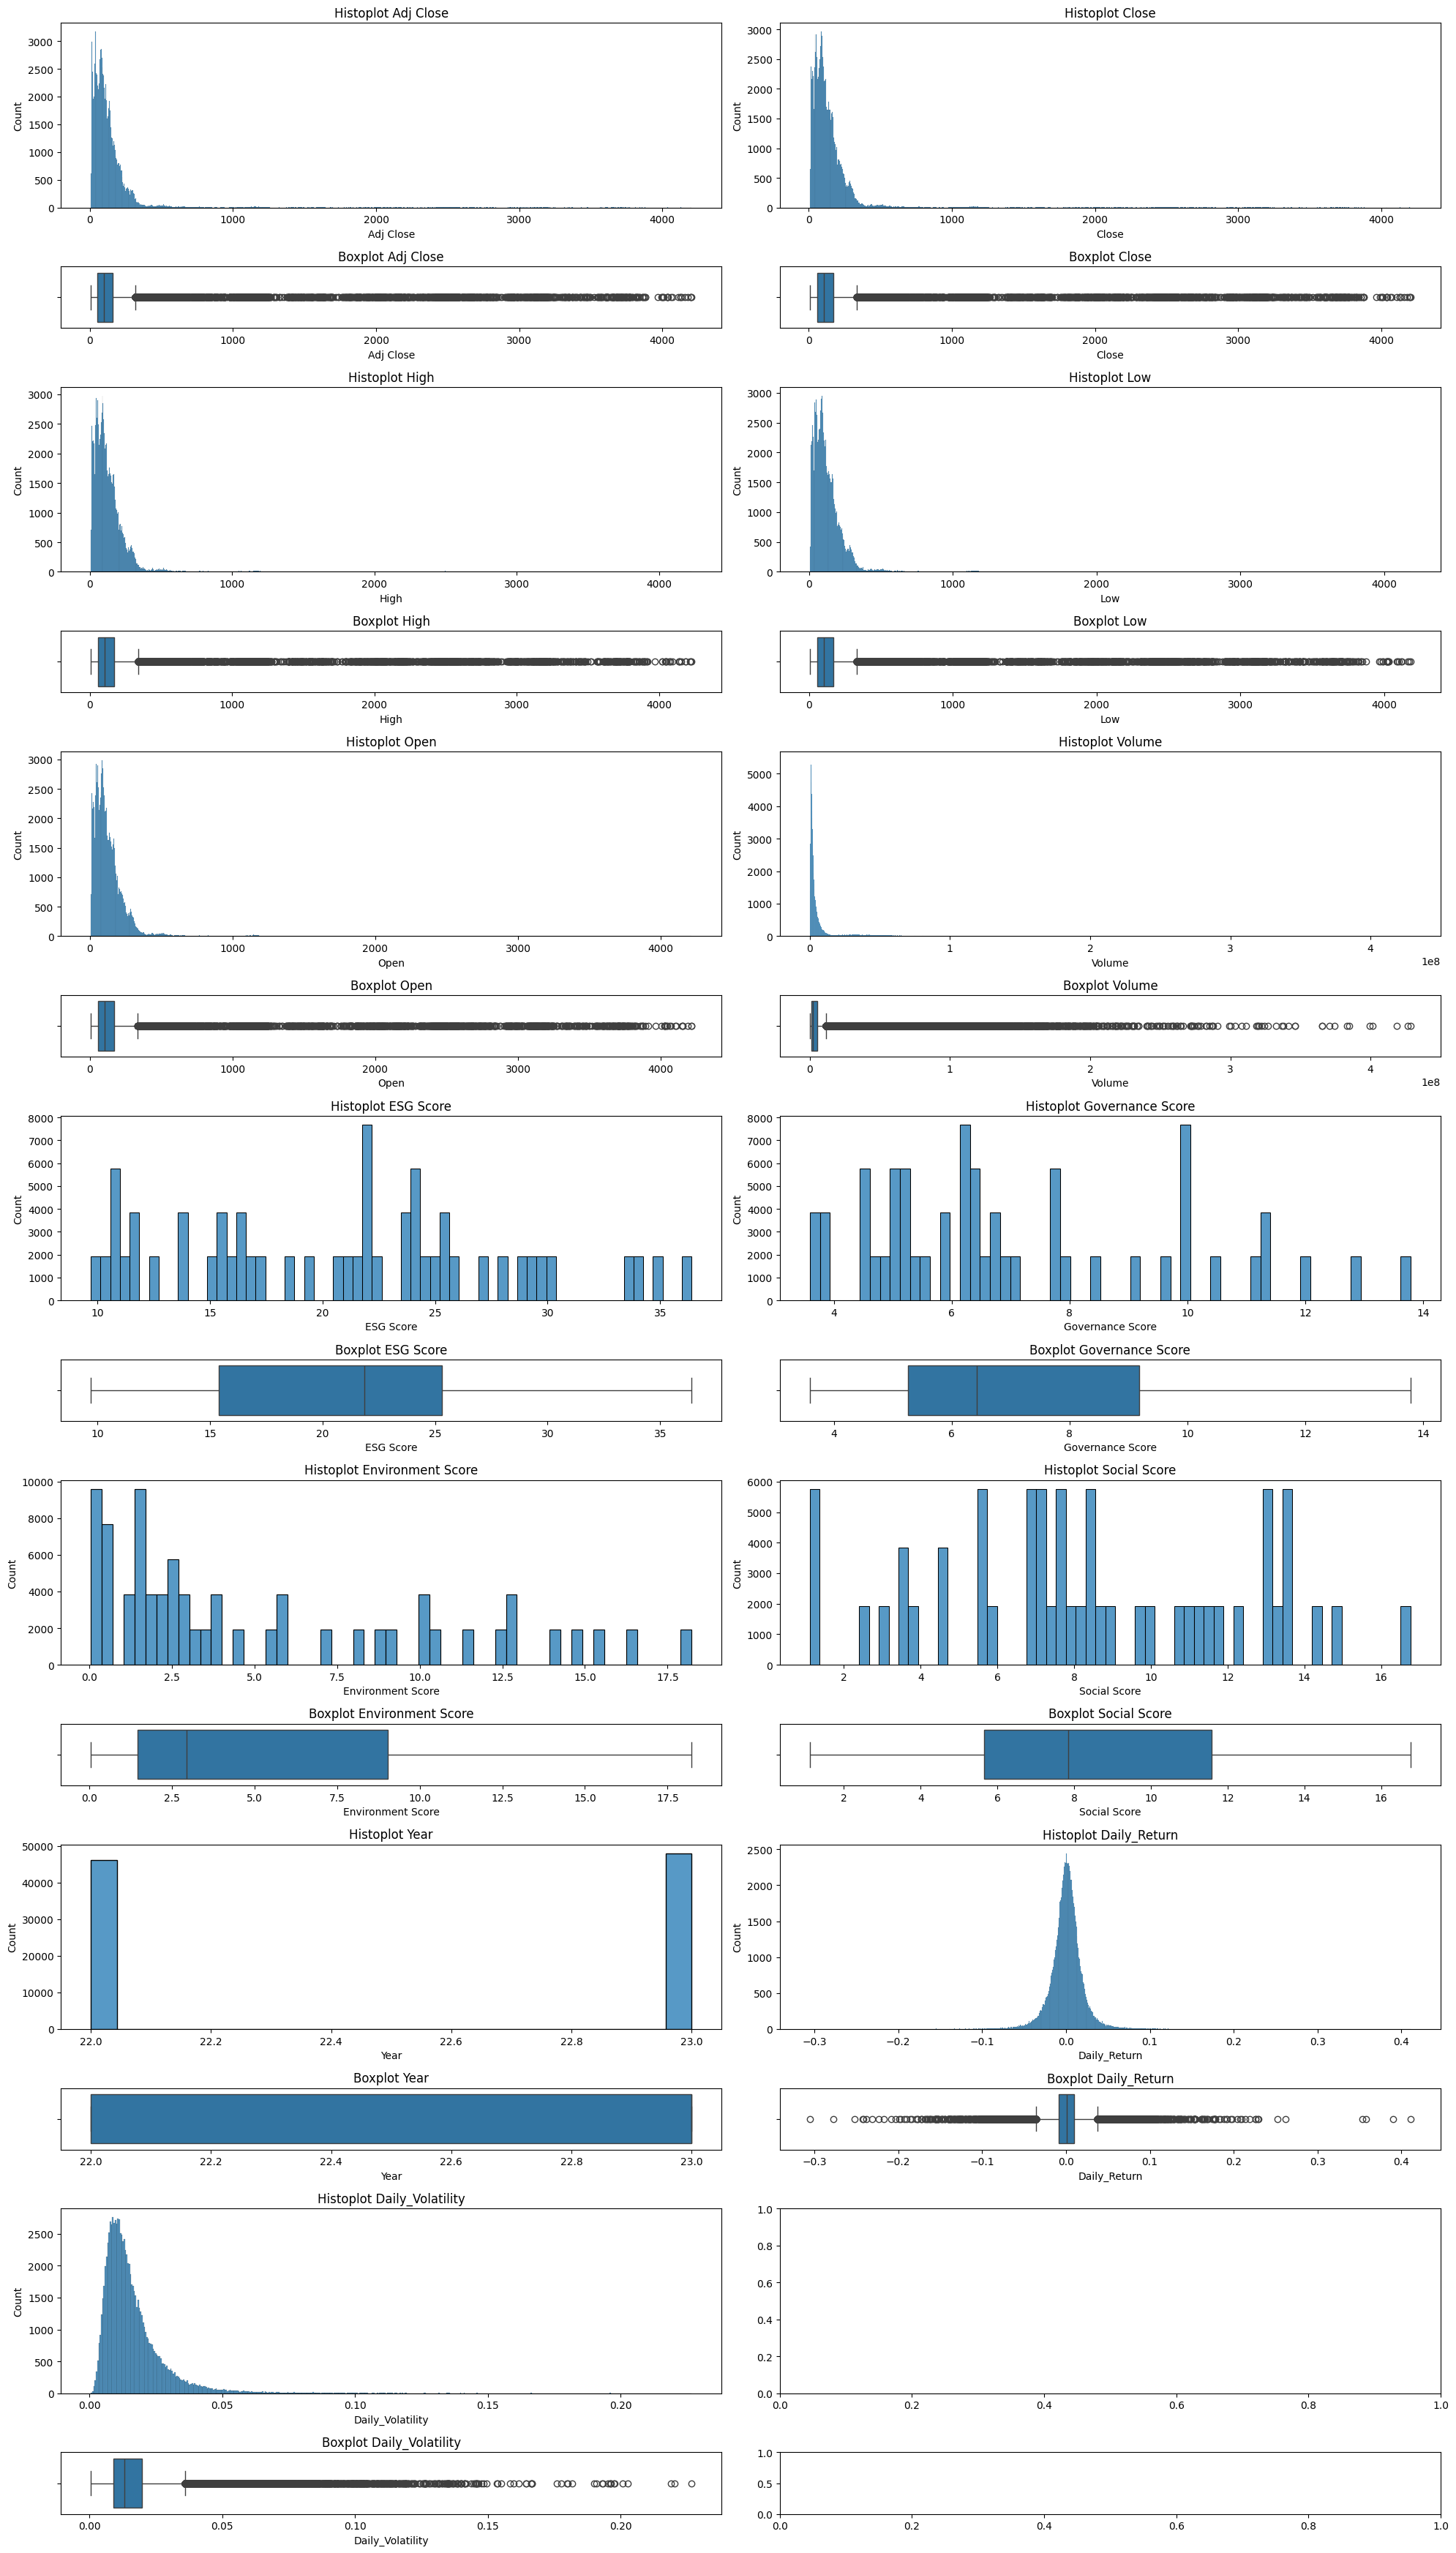

In [17]:
import matplotlib.pyplot as plt 
import seaborn as sns

numerical_variables = dataset_final.select_dtypes(include='number').columns
num_vars = len(numerical_variables)

# Number of rows: 2 per variable(histoplot + boxplot), 2 columns per row
ncols = 2
nrows = num_vars // ncols + (num_vars % ncols)
total_rows = nrows * 2  # double per variable.

fig, axes = plt.subplots(
    nrows=total_rows,
    ncols=ncols,
    figsize=(20, total_rows * 2.5),
    gridspec_kw={"height_ratios": [6, 2] * nrows}
)

axes = axes.reshape(total_rows, ncols)

# Automatic plot
for i, var in enumerate(numerical_variables):
    row = (i // ncols) * 2
    col = i % ncols

    # Histoplot
    sns.histplot(data=dataset_final, x=var, ax=axes[row, col])
    axes[row, col].set_title(f"Histoplot {var}")

    # Boxplot
    sns.boxplot(data=dataset_final, x=var, ax=axes[row + 1, col])
    axes[row + 1, col].set_title(f"Boxplot {var}")


plt.tight_layout()
plt.show()


In [18]:
# CATEGÓRICAS

categorical_variables = dataset_final.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Variables:", categorical_variables)

Categorical Variables: ['Ticker', 'ESG Score Date', 'ESG Status', 'CEO Gender']


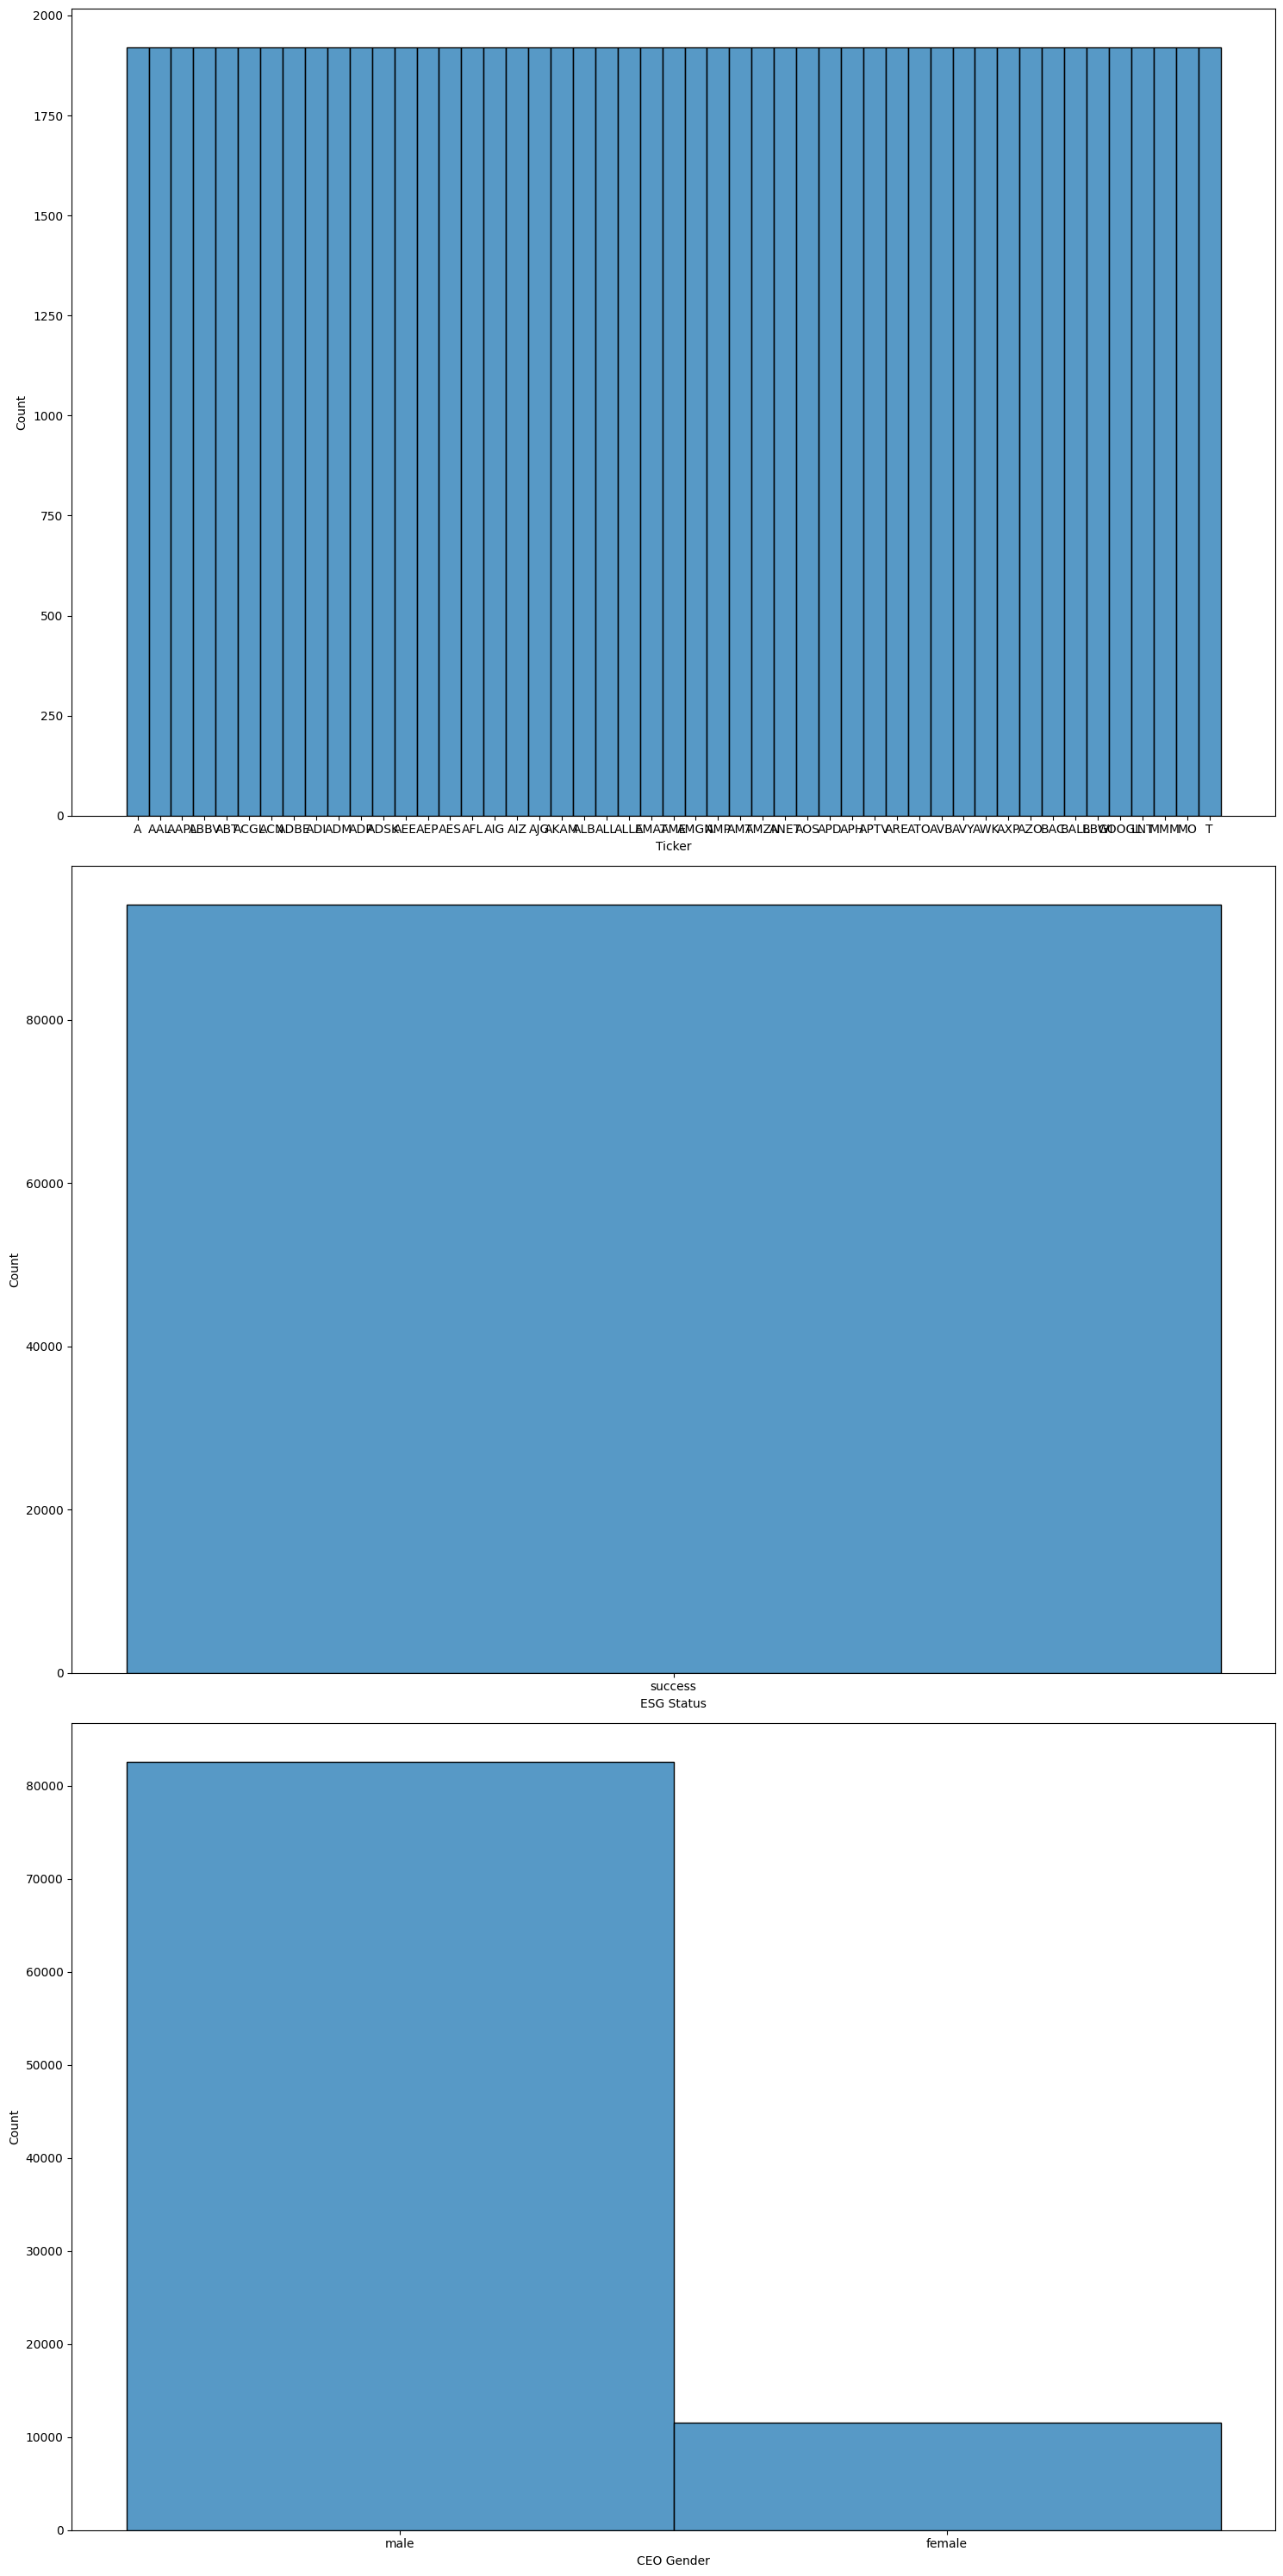

In [19]:

fig, axis = plt.subplots(3, figsize=(15, 30))

# Create a multiple histogram
sns.histplot(ax = axis[0], data = dataset_final, x = "Ticker") 
sns.histplot(ax = axis[1], data = dataset_final, x = "ESG Status")
sns.histplot(ax = axis[2], data = dataset_final, x = "CEO Gender")

plt.tight_layout()
plt.show()

In [20]:
#MULTIVARIANTE: numérico-numérico

numerical_variables

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ESG Score',
       'Governance Score', 'Environment Score', 'Social Score', 'Year',
       'Daily_Return', 'Daily_Volatility'],
      dtype='object')

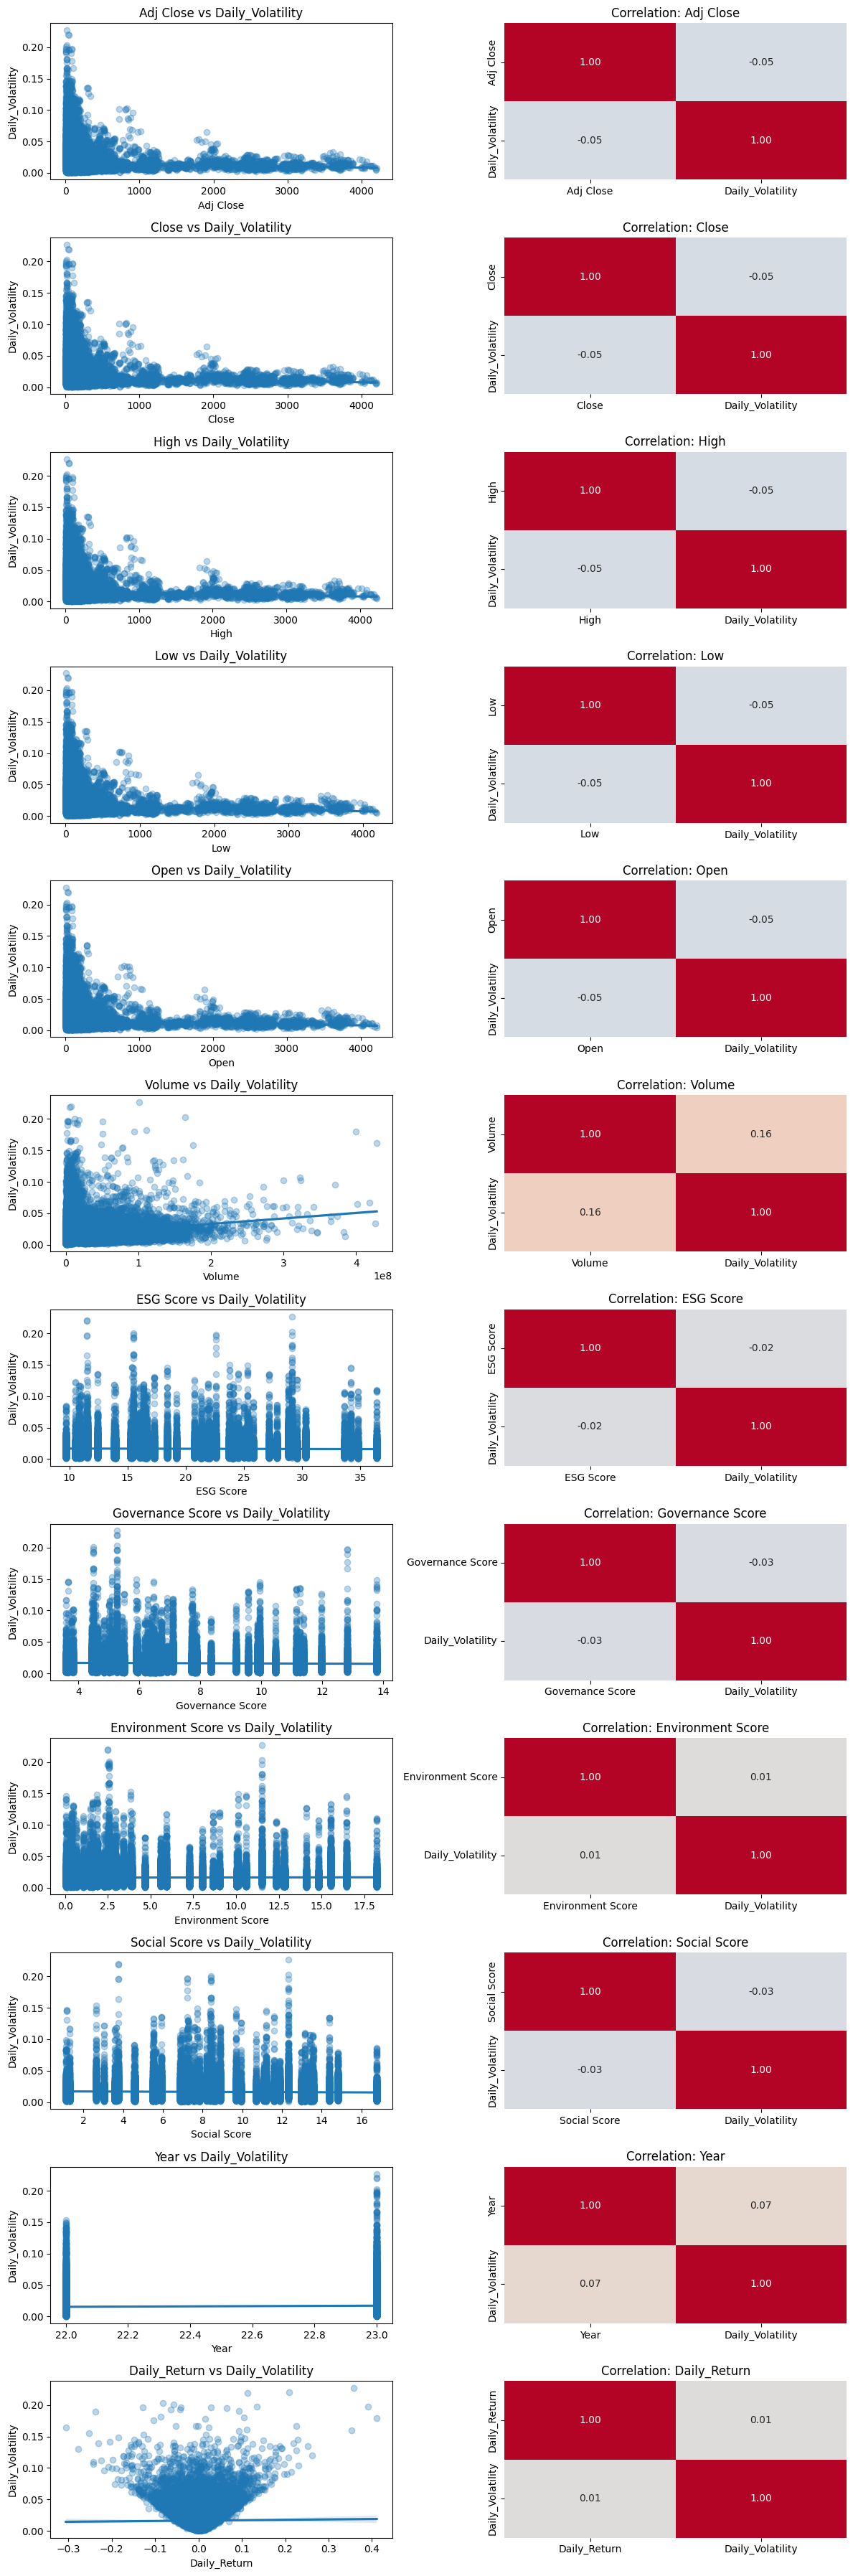

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables que quieres comparar con Daily_Volatility
variables = [
    "Adj Close", "Close", "High", "Low", "Open", "Volume",
    "ESG Score", "Governance Score", "Environment Score",
    "Social Score", "Year", "Daily_Return"
]

n_vars = len(variables)
ncols = 2   # un regplot y un heatmap por fila
nrows = n_vars  # una fila por variable

fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(12, nrows * 3)
)

# Si solo hay 1 fila, convertir axes a 2D para que no dé error
if nrows == 1:
    axes = [axes]

for i, var in enumerate(variables):
    # Regplot a la izquierda
    sns.regplot(
        ax=axes[i, 0], 
        data=dataset_final, 
        x=var, 
        y="Daily_Volatility", 
        scatter_kws={"alpha": 0.3}
    )
    axes[i, 0].set_title(f"{var} vs Daily_Volatility")

    # Heatmap a la derecha
    corr = dataset_final[[var, "Daily_Volatility"]].corr()
    sns.heatmap(
        corr, 
        annot=True, 
        fmt=".2f", 
        ax=axes[i, 1], 
        cbar=False, 
        cmap="coolwarm",
        vmin=-1, vmax=1
    )
    axes[i, 1].set_title(f"Correlation: {var}")

plt.tight_layout()
plt.show()


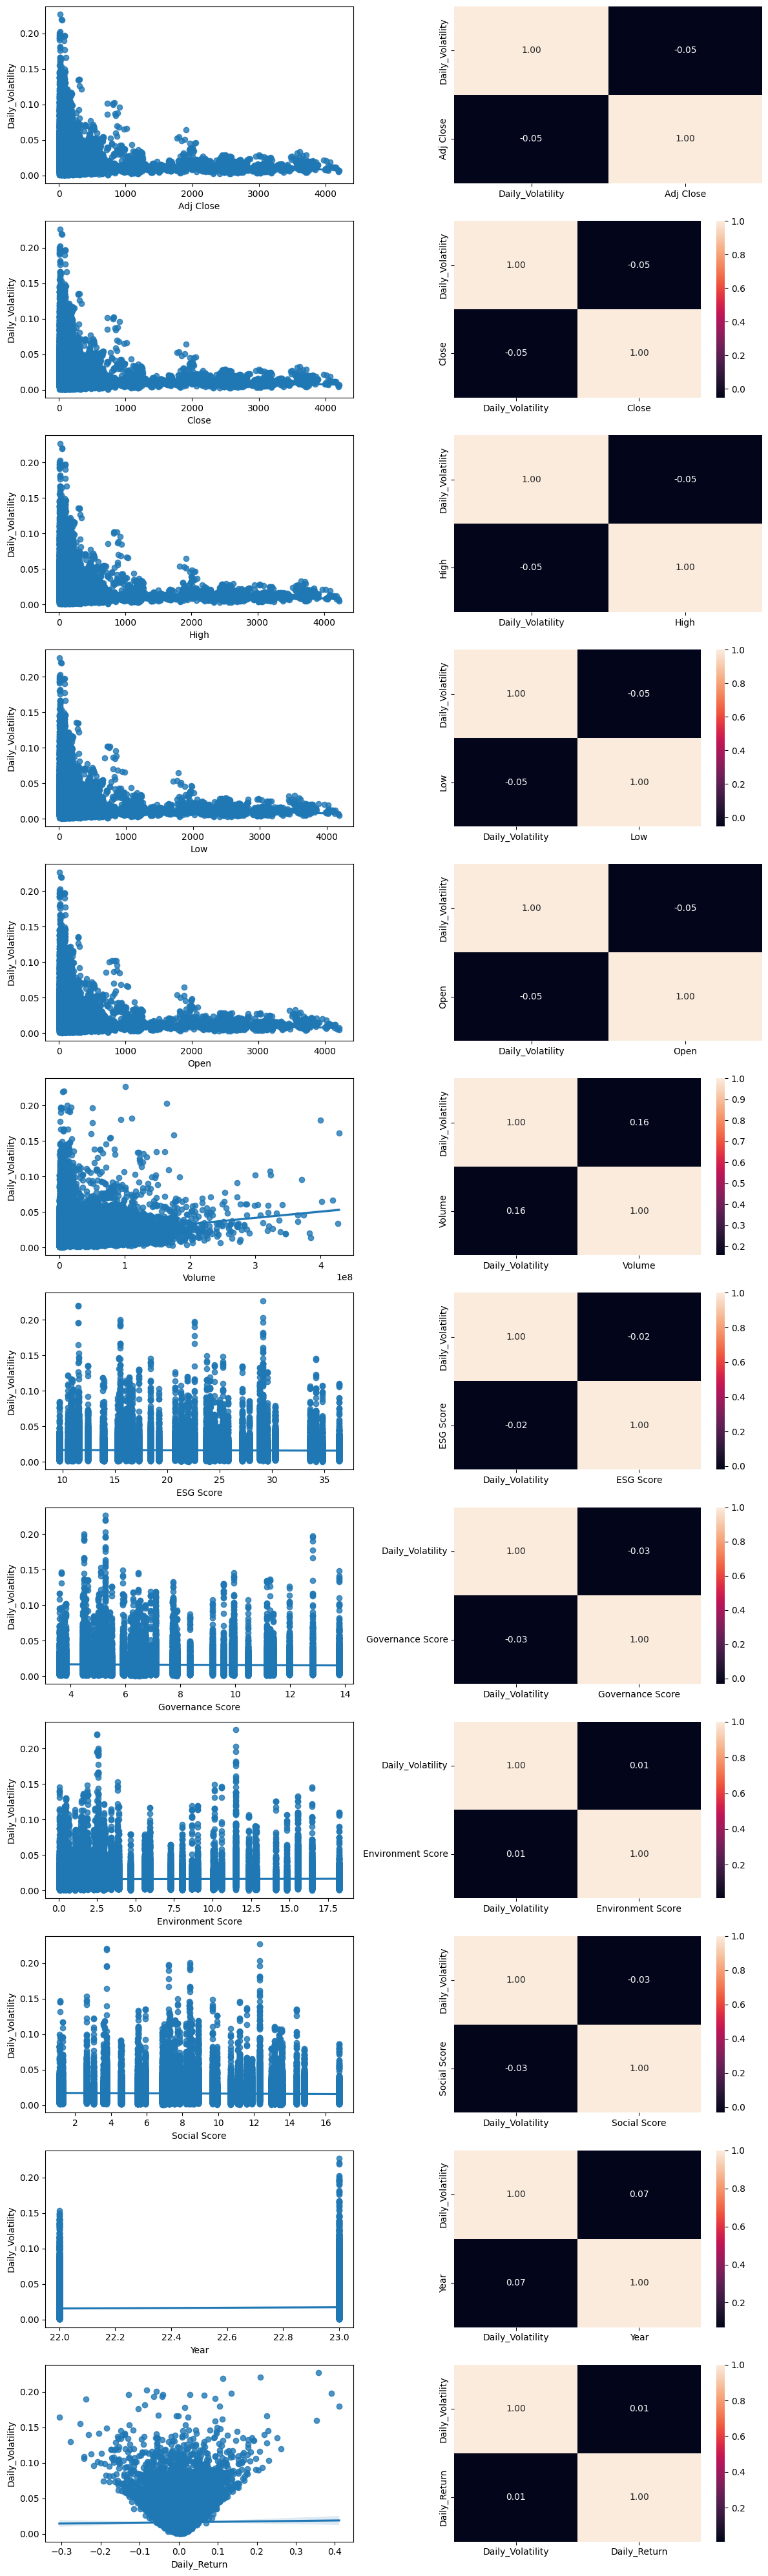

In [22]:
fig, axis = plt.subplots(12, 2, figsize=(12, 40))  # 12 variables → 12 filas x 2 columnas

sns.regplot(ax=axis[0, 0], data=dataset_final, x="Adj Close", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Adj Close"]].corr(), annot=True, fmt=".2f", ax=axis[0, 1], cbar=False)

sns.regplot(ax=axis[1, 0], data=dataset_final, x="Close", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Close"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

sns.regplot(ax=axis[2, 0], data=dataset_final, x="High", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "High"]].corr(), annot=True, fmt=".2f", ax=axis[2, 1], cbar=False)

sns.regplot(ax=axis[3, 0], data=dataset_final, x="Low", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Low"]].corr(), annot=True, fmt=".2f", ax=axis[3, 1])

sns.regplot(ax=axis[4, 0], data=dataset_final, x="Open", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Open"]].corr(), annot=True, fmt=".2f", ax=axis[4, 1], cbar=False)

sns.regplot(ax=axis[5, 0], data=dataset_final, x="Volume", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Volume"]].corr(), annot=True, fmt=".2f", ax=axis[5, 1])

sns.regplot(ax=axis[6, 0], data=dataset_final, x="ESG Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "ESG Score"]].corr(), annot=True, fmt=".2f", ax=axis[6, 1])

sns.regplot(ax=axis[7, 0], data=dataset_final, x="Governance Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Governance Score"]].corr(), annot=True, fmt=".2f", ax=axis[7, 1])

sns.regplot(ax=axis[8, 0], data=dataset_final, x="Environment Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Environment Score"]].corr(), annot=True, fmt=".2f", ax=axis[8, 1])

sns.regplot(ax=axis[9, 0], data=dataset_final, x="Social Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Social Score"]].corr(), annot=True, fmt=".2f", ax=axis[9, 1])

sns.regplot(ax=axis[10, 0], data=dataset_final, x="Year", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Year"]].corr(), annot=True, fmt=".2f", ax=axis[10, 1])

sns.regplot(ax=axis[11, 0], data=dataset_final, x="Daily_Return", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Daily_Return"]].corr(), annot=True, fmt=".2f", ax=axis[11, 1])

plt.tight_layout()
plt.show()


MULTIVARIANTE CATEGÓRICO-CATEGÓRICO

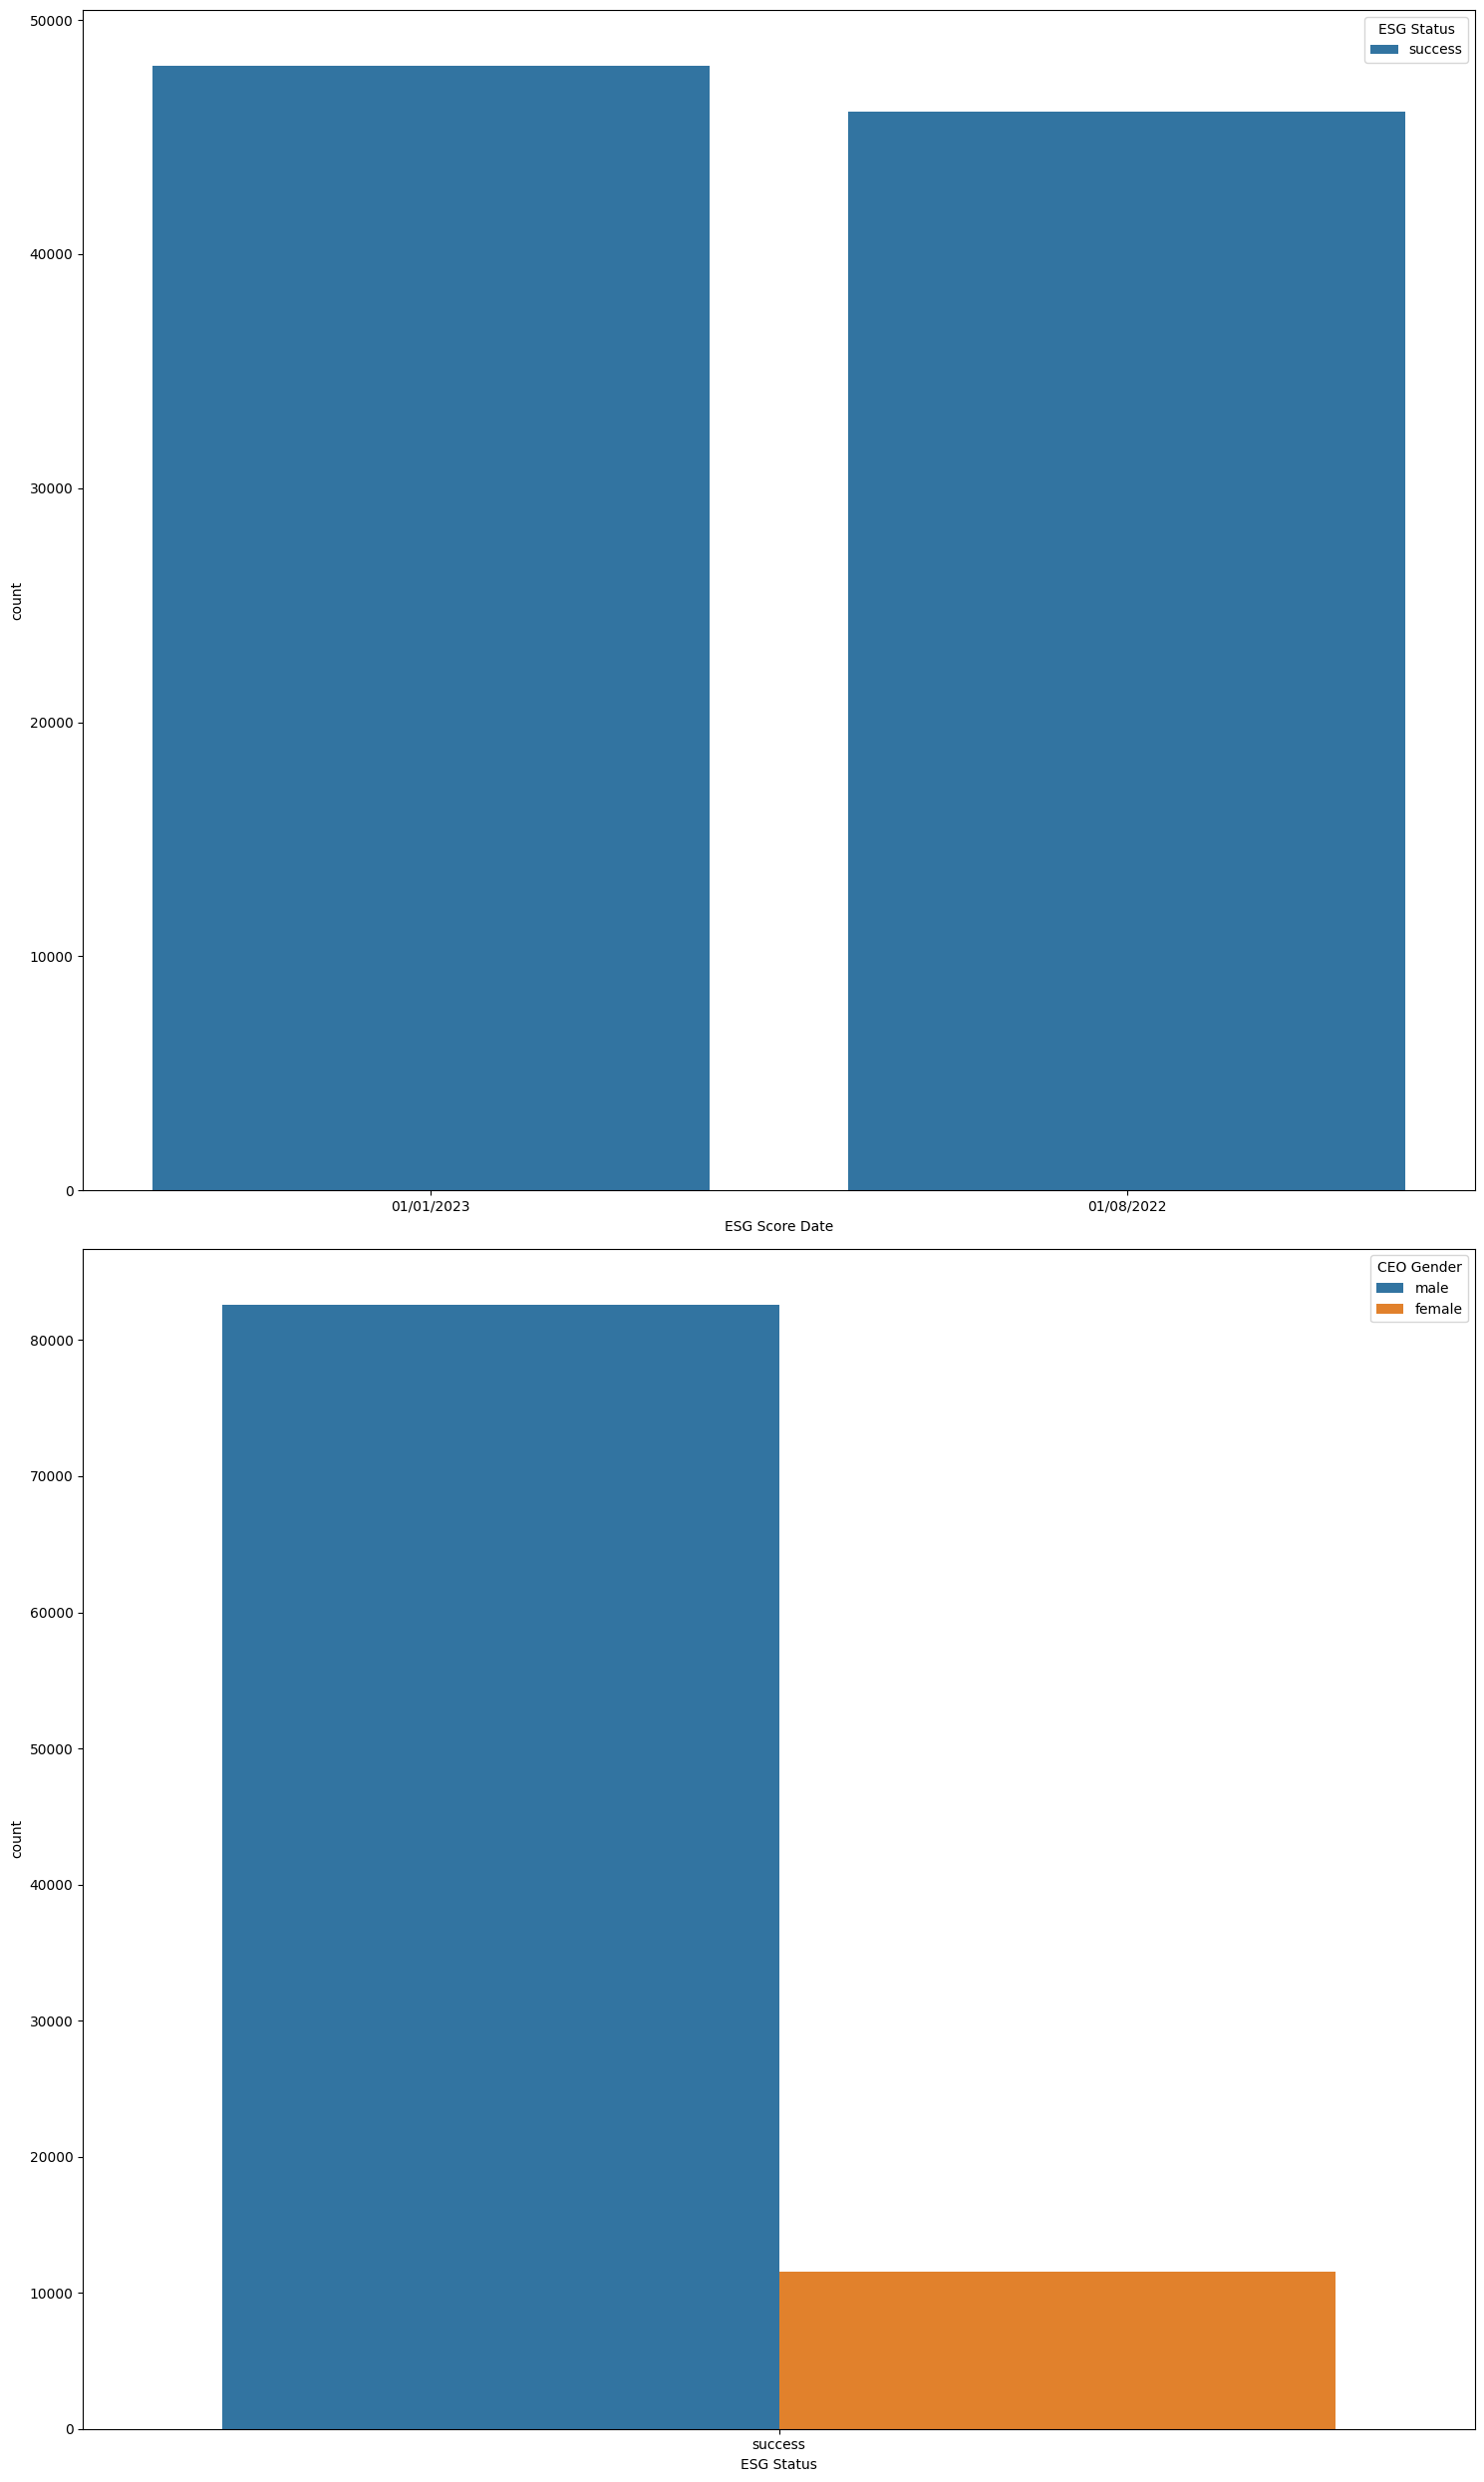

In [23]:
fig, axis = plt.subplots(2, 1, figsize=(15, 25))  

sns.countplot(data=dataset_final, x="ESG Score Date", hue="ESG Status", ax=axis[0])
sns.countplot(data=dataset_final, x="ESG Status", hue="CEO Gender", ax=axis[1])

plt.tight_layout()
plt.show()


## A revisar

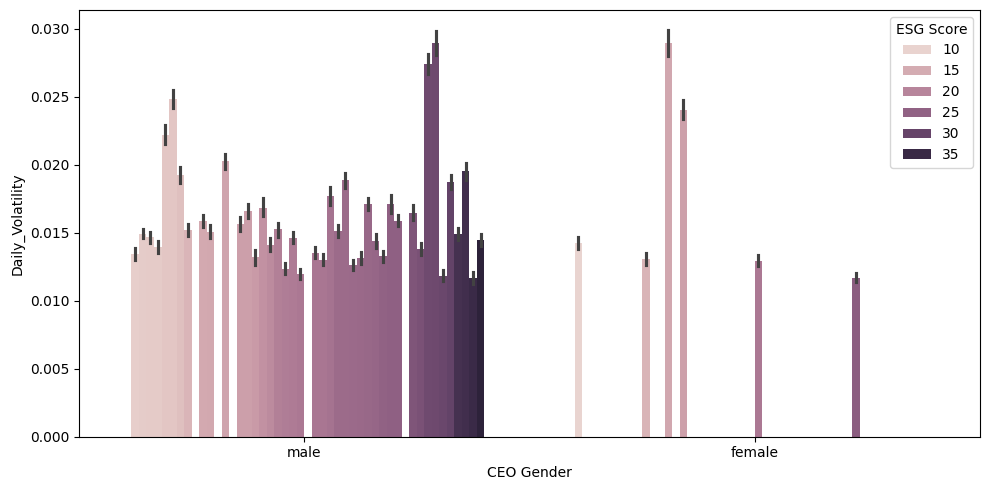

In [24]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 1)

sns.barplot(data = dataset_final, x = "CEO Gender", y = "Daily_Volatility", hue = "ESG Score")

plt.tight_layout()

plt.show()

# ANÁLISIS DE CORRELACIONES

In [25]:
import json 

categorical_f_rules = {}

for col in categorical_variables:
    encoded_col = f"{col}_n"
    dataset_final[encoded_col], uniques = pd.factorize(dataset_final[col])
    dicc = dict(zip(uniques, range(len(uniques))))
    categorical_f_rules[col] = dicc

with open("categorical_rules.json", "w") as f:
    json.dump(categorical_f_rules, f)

with open("categorical_rules.json", "r") as f:
    loaded_mappings = json.load(f)

dataset_final.head()

Date Ticker  Adj Close      Close       High        Low       Open  \
5 2018-01-09      A  67.851921  71.769997  72.330002  70.169998  70.680000   
6 2018-01-10      A  66.925446  70.790001  71.449997  70.110001  71.449997   
7 2018-01-11      A  66.934891  70.800003  71.180000  70.300003  70.919998   
8 2018-01-12      A  67.814125  71.730003  71.860001  70.500000  70.730003   
9 2018-01-16      A  67.341408  71.230003  72.470001  71.059998  72.019997   

      Volume  ESG Score  Governance Score  ...  ESG Score Date  ESG Status  \
5  2666100.0      15.24              6.26  ...      01/01/2023     success   
6  2957200.0      15.24              6.26  ...      01/01/2023     success   
7  1511100.0      15.24              6.26  ...      01/01/2023     success   
8  1448100.0      15.24              6.26  ...      01/01/2023     success   
9  1702700.0      15.24              6.26  ...      01/01/2023     success   

  CEO Gender Year Daily_Return  Daily_Volatility  Ticker_n  ESG Score Date_n  \
5       male   23     0.024553          0.014418         0                 0   
6       male   23    -0.013654          0.015915         0                 0   
7       male   23     0.000141          0.014827         0                 0   
8       male   23     0.013136          0.014387         0                 0   
9       male   23    -0.006971          0.015421         0                 0   

   ESG Status_n  CEO Gender_n  
5             0             0  
6             0             0  
7             0             0  
8             0             0  
9             0             0  

[5 rows x 22 columns]

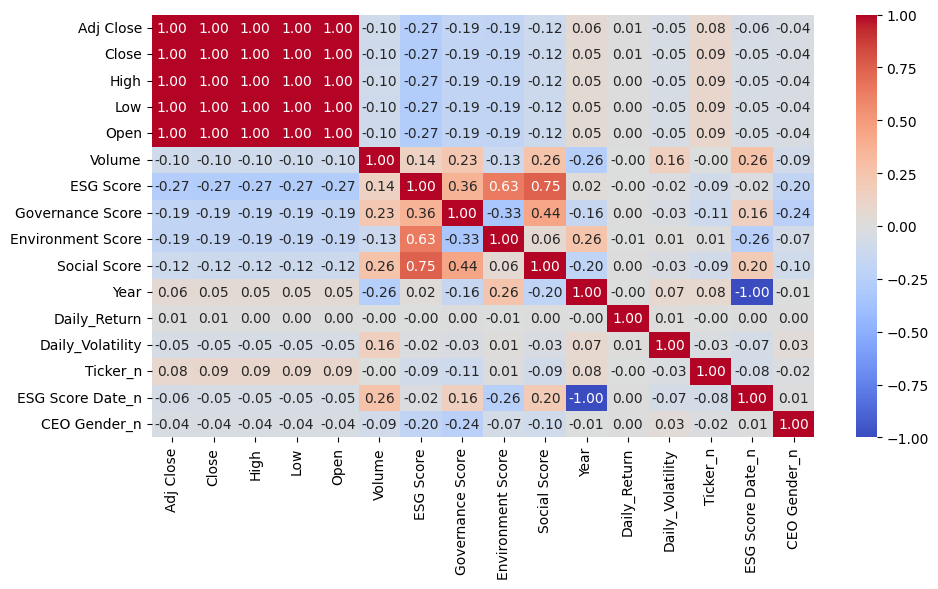

In [26]:
fig, axis = plt.subplots(figsize=(10, 6))

sns.heatmap(
    dataset_final[[
        "Adj Close", "Close", "High", "Low", "Open", "Volume",
        "ESG Score", "Governance Score", "Environment Score", "Social Score",
        "Year", "Daily_Return", "Daily_Volatility",
        "Ticker_n", "ESG Score Date_n",
        "CEO Gender_n"
    ]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)

plt.tight_layout()
plt.show()


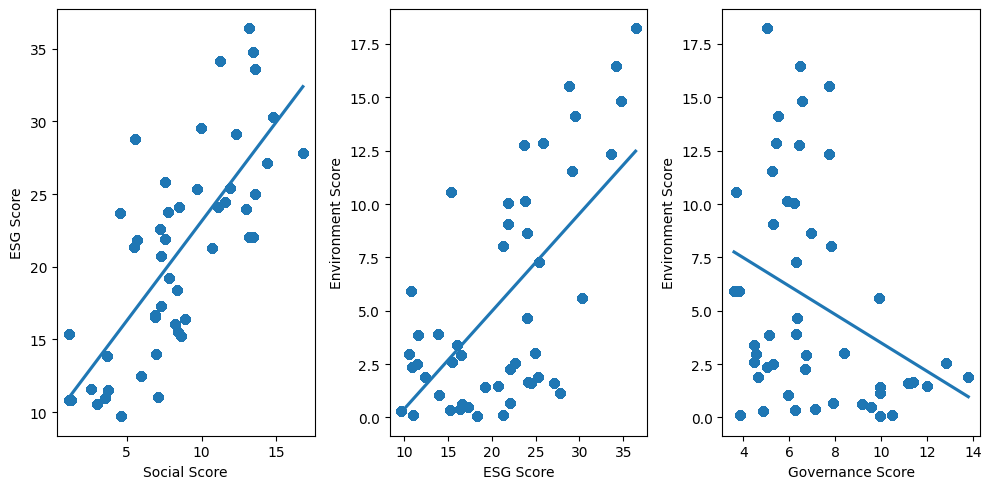

In [27]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 3)
sns.regplot(ax = axis[0], data = dataset_final, x = "Social Score", y = "ESG Score")
sns.regplot(ax = axis[1], data = dataset_final, x = "ESG Score", y = "Environment Score")
sns.regplot(ax = axis[2], data = dataset_final, x = "Governance Score", y = "Environment Score")

plt.tight_layout()
plt.show()

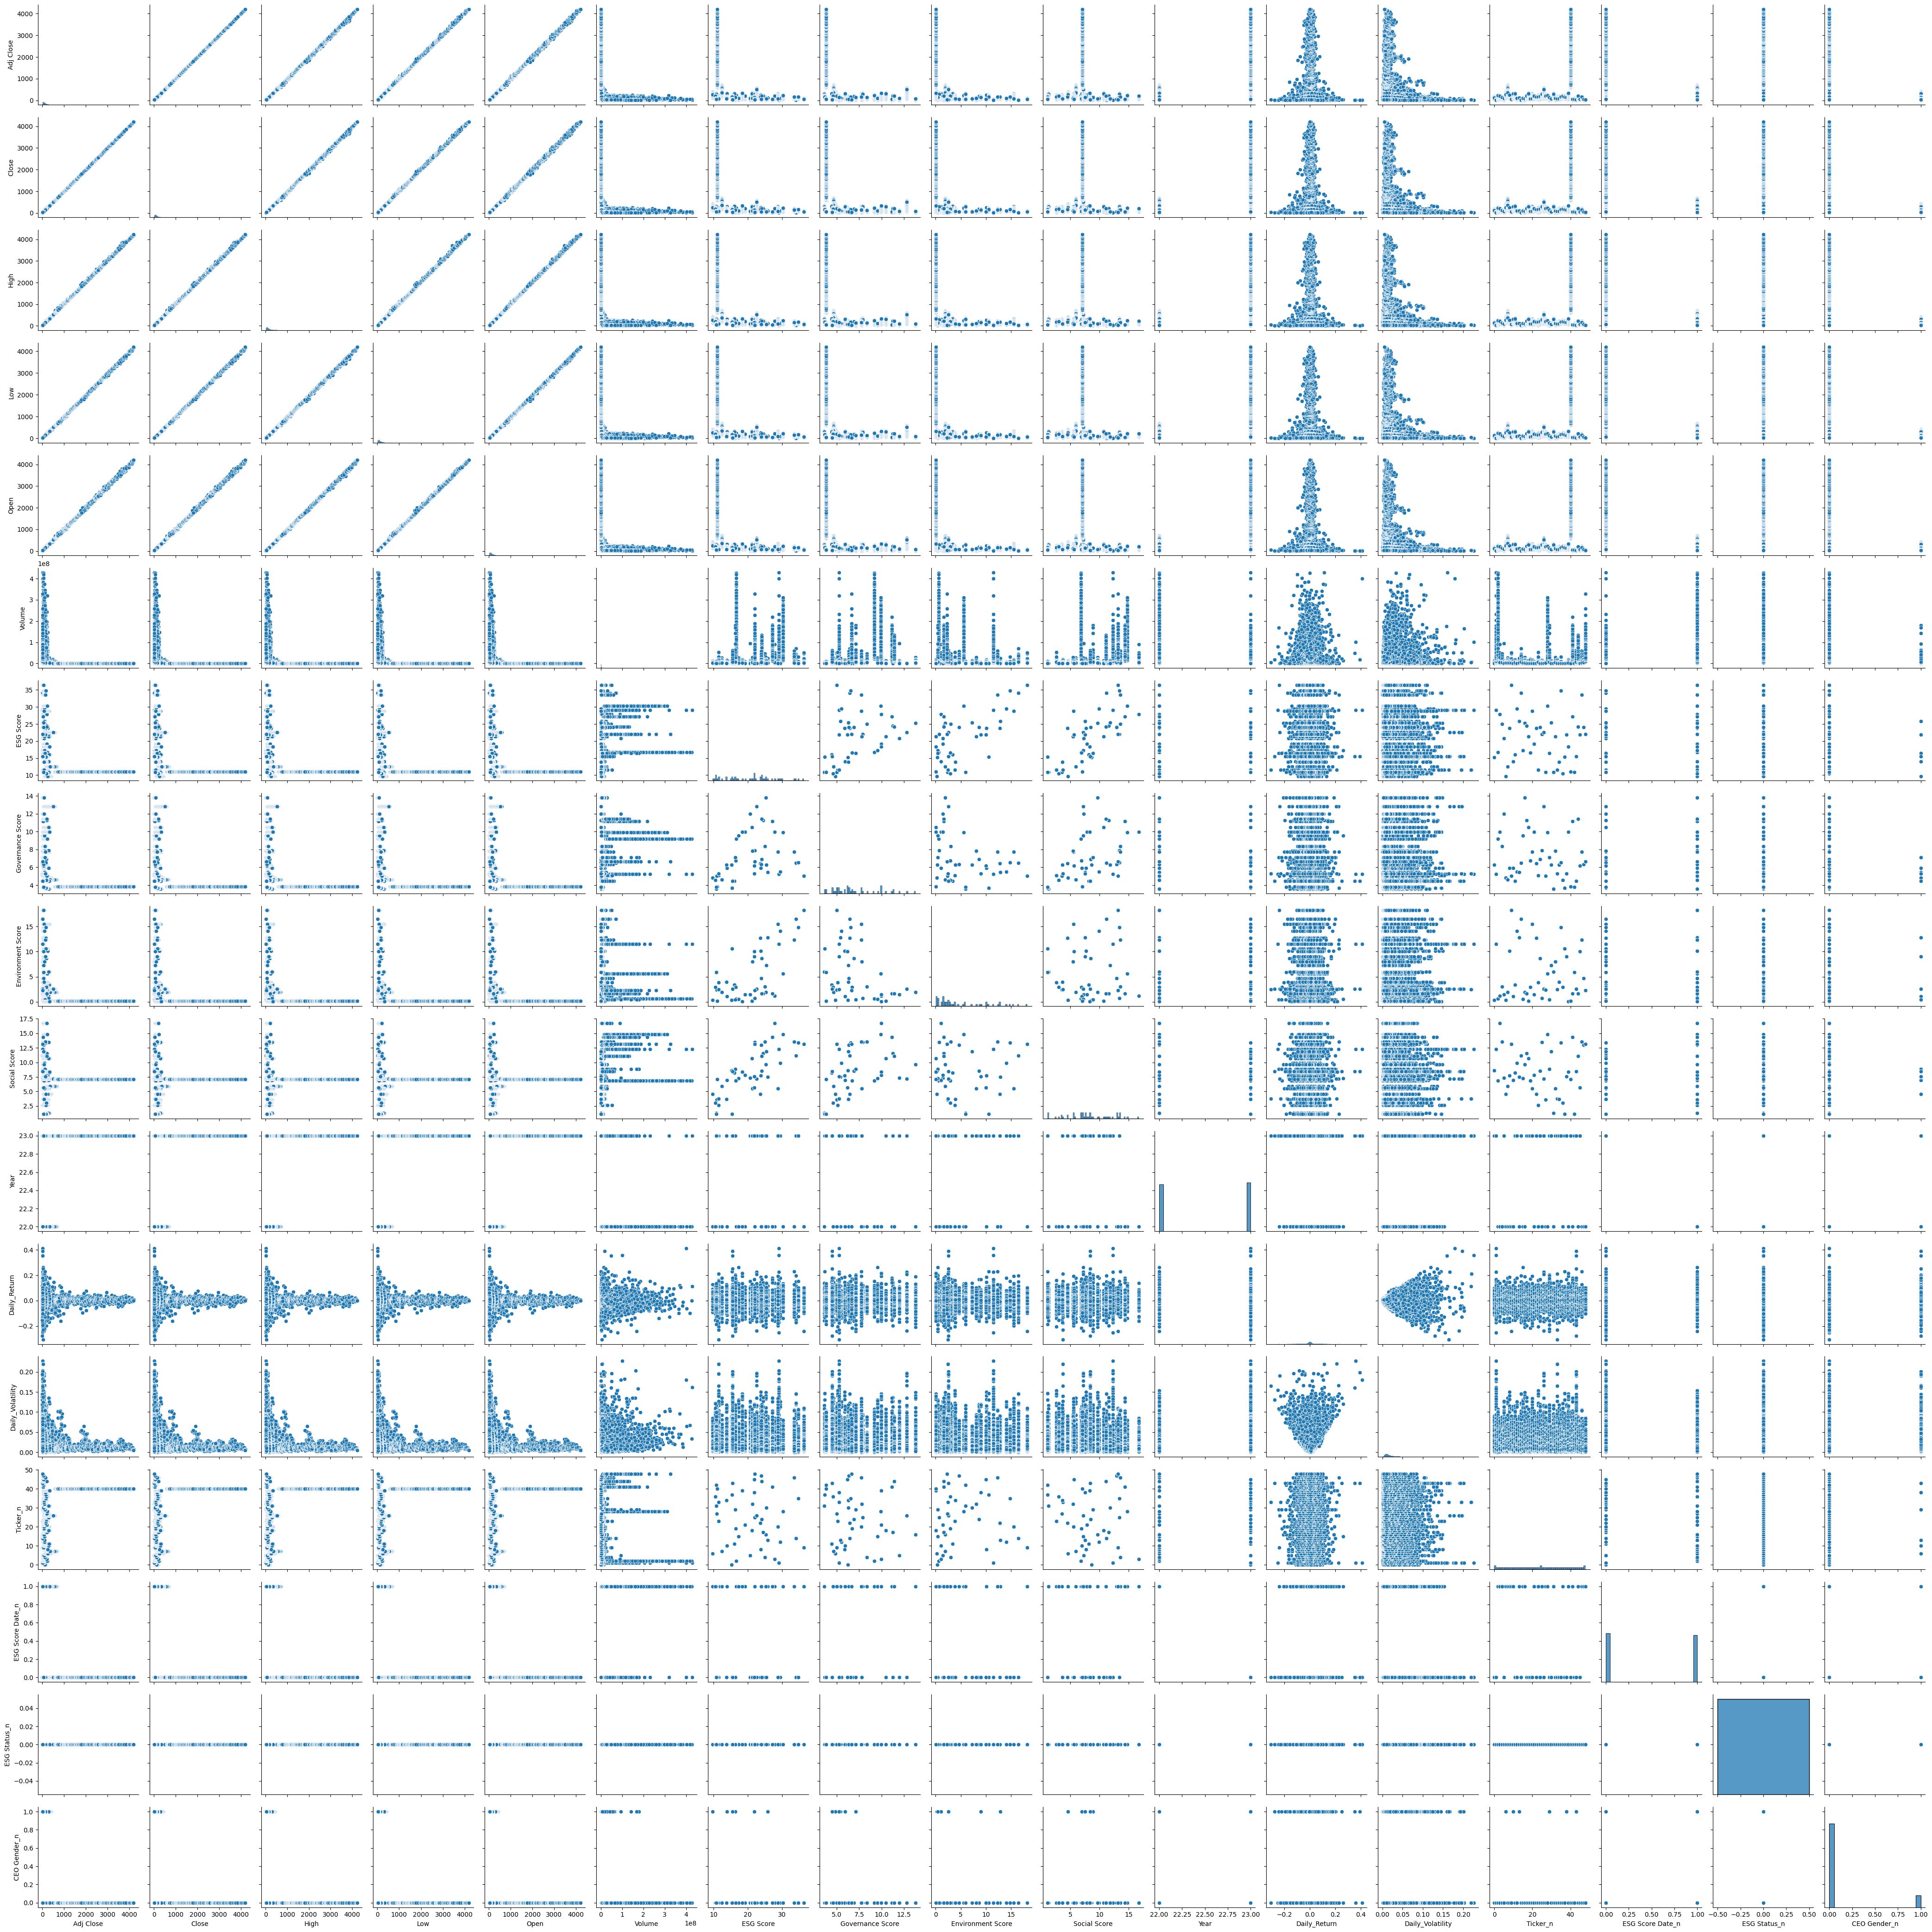

In [28]:
sns.pairplot(data = dataset_final)

In [29]:
dataset_final.describe()

Date     Adj Close         Close  \
count                          94129  94129.000000  94129.000000   
mean   2021-11-02 08:13:14.586152960    152.382872    159.591134   
min              2018-01-09 00:00:00      6.781555      7.413096   
25%              2019-12-05 00:00:00     54.170822     58.808498   
50%              2021-11-01 00:00:00     97.430328    104.320000   
75%              2023-09-29 00:00:00    159.060226    169.880005   
max              2025-08-29 00:00:00   4205.410156   4205.410156   
std                              NaN    298.454138    298.066856   

               High           Low          Open        Volume     ESG Score  \
count  94129.000000  94129.000000  94129.000000  9.412900e+04  94129.000000   
mean     161.276196    157.801603    159.558131  9.406241e+06     20.921020   
min        7.881973      6.467259      7.631366  3.750000e+04      9.710000   
25%       59.439999     58.169998     58.799500  1.097700e+06     15.380000   
50%      105.379997    103.129997    104.300003  2.215100e+06     21.870000   
75%      171.559998    168.169998    169.832779  5.254500e+06     25.320000   
max     4229.680176   4182.259766   4216.020020  4.286171e+08     36.400000   
std      300.864680    294.903649    297.852151  2.262586e+07      7.098445   

       Governance Score  Environment Score  Social Score          Year  \
count      94129.000000       94129.000000  94129.000000  94129.000000   
mean           7.154490           5.382449      8.384286     22.510204   
min            3.590000           0.050000      1.110000     22.000000   
25%            5.260000           1.470000      5.650000     22.000000   
50%            6.430000           2.950000      7.850000     23.000000   
75%            9.180000           9.040000     11.580000     23.000000   
max           13.790000          18.230000     16.770000     23.000000   
std            2.571811           5.134039      3.886242      0.499899   

       Daily_Return  Daily_Volatility      Ticker_n  ESG Score Date_n  \
count  94129.000000      94129.000000  94129.000000      94129.000000   
mean       0.000602          0.016314     24.000000          0.489796   
min       -0.305527          0.000479      0.000000          0.000000   
25%       -0.008379          0.008870     12.000000          0.000000   
50%        0.000917          0.013160     24.000000          0.000000   
75%        0.009996          0.019666     36.000000          1.000000   
max        0.410970          0.226741     48.000000          1.000000   
std        0.020392          0.012592     14.142211          0.499899   

       ESG Status_n  CEO Gender_n  
count       94129.0  94129.000000  
mean            0.0      0.122449  
min             0.0      0.000000  
25%             0.0      0.000000  
50%             0.0      0.000000  
75%             0.0      0.000000  
max             0.0      1.000000  
std             0.0      0.327805

OUTLIERS

In [30]:
dataset_final.describe()

Date     Adj Close         Close  \
count                          94129  94129.000000  94129.000000   
mean   2021-11-02 08:13:14.586152960    152.382872    159.591134   
min              2018-01-09 00:00:00      6.781555      7.413096   
25%              2019-12-05 00:00:00     54.170822     58.808498   
50%              2021-11-01 00:00:00     97.430328    104.320000   
75%              2023-09-29 00:00:00    159.060226    169.880005   
max              2025-08-29 00:00:00   4205.410156   4205.410156   
std                              NaN    298.454138    298.066856   

               High           Low          Open        Volume     ESG Score  \
count  94129.000000  94129.000000  94129.000000  9.412900e+04  94129.000000   
mean     161.276196    157.801603    159.558131  9.406241e+06     20.921020   
min        7.881973      6.467259      7.631366  3.750000e+04      9.710000   
25%       59.439999     58.169998     58.799500  1.097700e+06     15.380000   
50%      105.379997    103.129997    104.300003  2.215100e+06     21.870000   
75%      171.559998    168.169998    169.832779  5.254500e+06     25.320000   
max     4229.680176   4182.259766   4216.020020  4.286171e+08     36.400000   
std      300.864680    294.903649    297.852151  2.262586e+07      7.098445   

       Governance Score  Environment Score  Social Score          Year  \
count      94129.000000       94129.000000  94129.000000  94129.000000   
mean           7.154490           5.382449      8.384286     22.510204   
min            3.590000           0.050000      1.110000     22.000000   
25%            5.260000           1.470000      5.650000     22.000000   
50%            6.430000           2.950000      7.850000     23.000000   
75%            9.180000           9.040000     11.580000     23.000000   
max           13.790000          18.230000     16.770000     23.000000   
std            2.571811           5.134039      3.886242      0.499899   

       Daily_Return  Daily_Volatility      Ticker_n  ESG Score Date_n  \
count  94129.000000      94129.000000  94129.000000      94129.000000   
mean       0.000602          0.016314     24.000000          0.489796   
min       -0.305527          0.000479      0.000000          0.000000   
25%       -0.008379          0.008870     12.000000          0.000000   
50%        0.000917          0.013160     24.000000          0.000000   
75%        0.009996          0.019666     36.000000          1.000000   
max        0.410970          0.226741     48.000000          1.000000   
std        0.020392          0.012592     14.142211          0.499899   

       ESG Status_n  CEO Gender_n  
count       94129.0  94129.000000  
mean            0.0      0.122449  
min             0.0      0.000000  
25%             0.0      0.000000  
50%             0.0      0.000000  
75%             0.0      0.000000  
max             0.0      1.000000  
std             0.0      0.327805

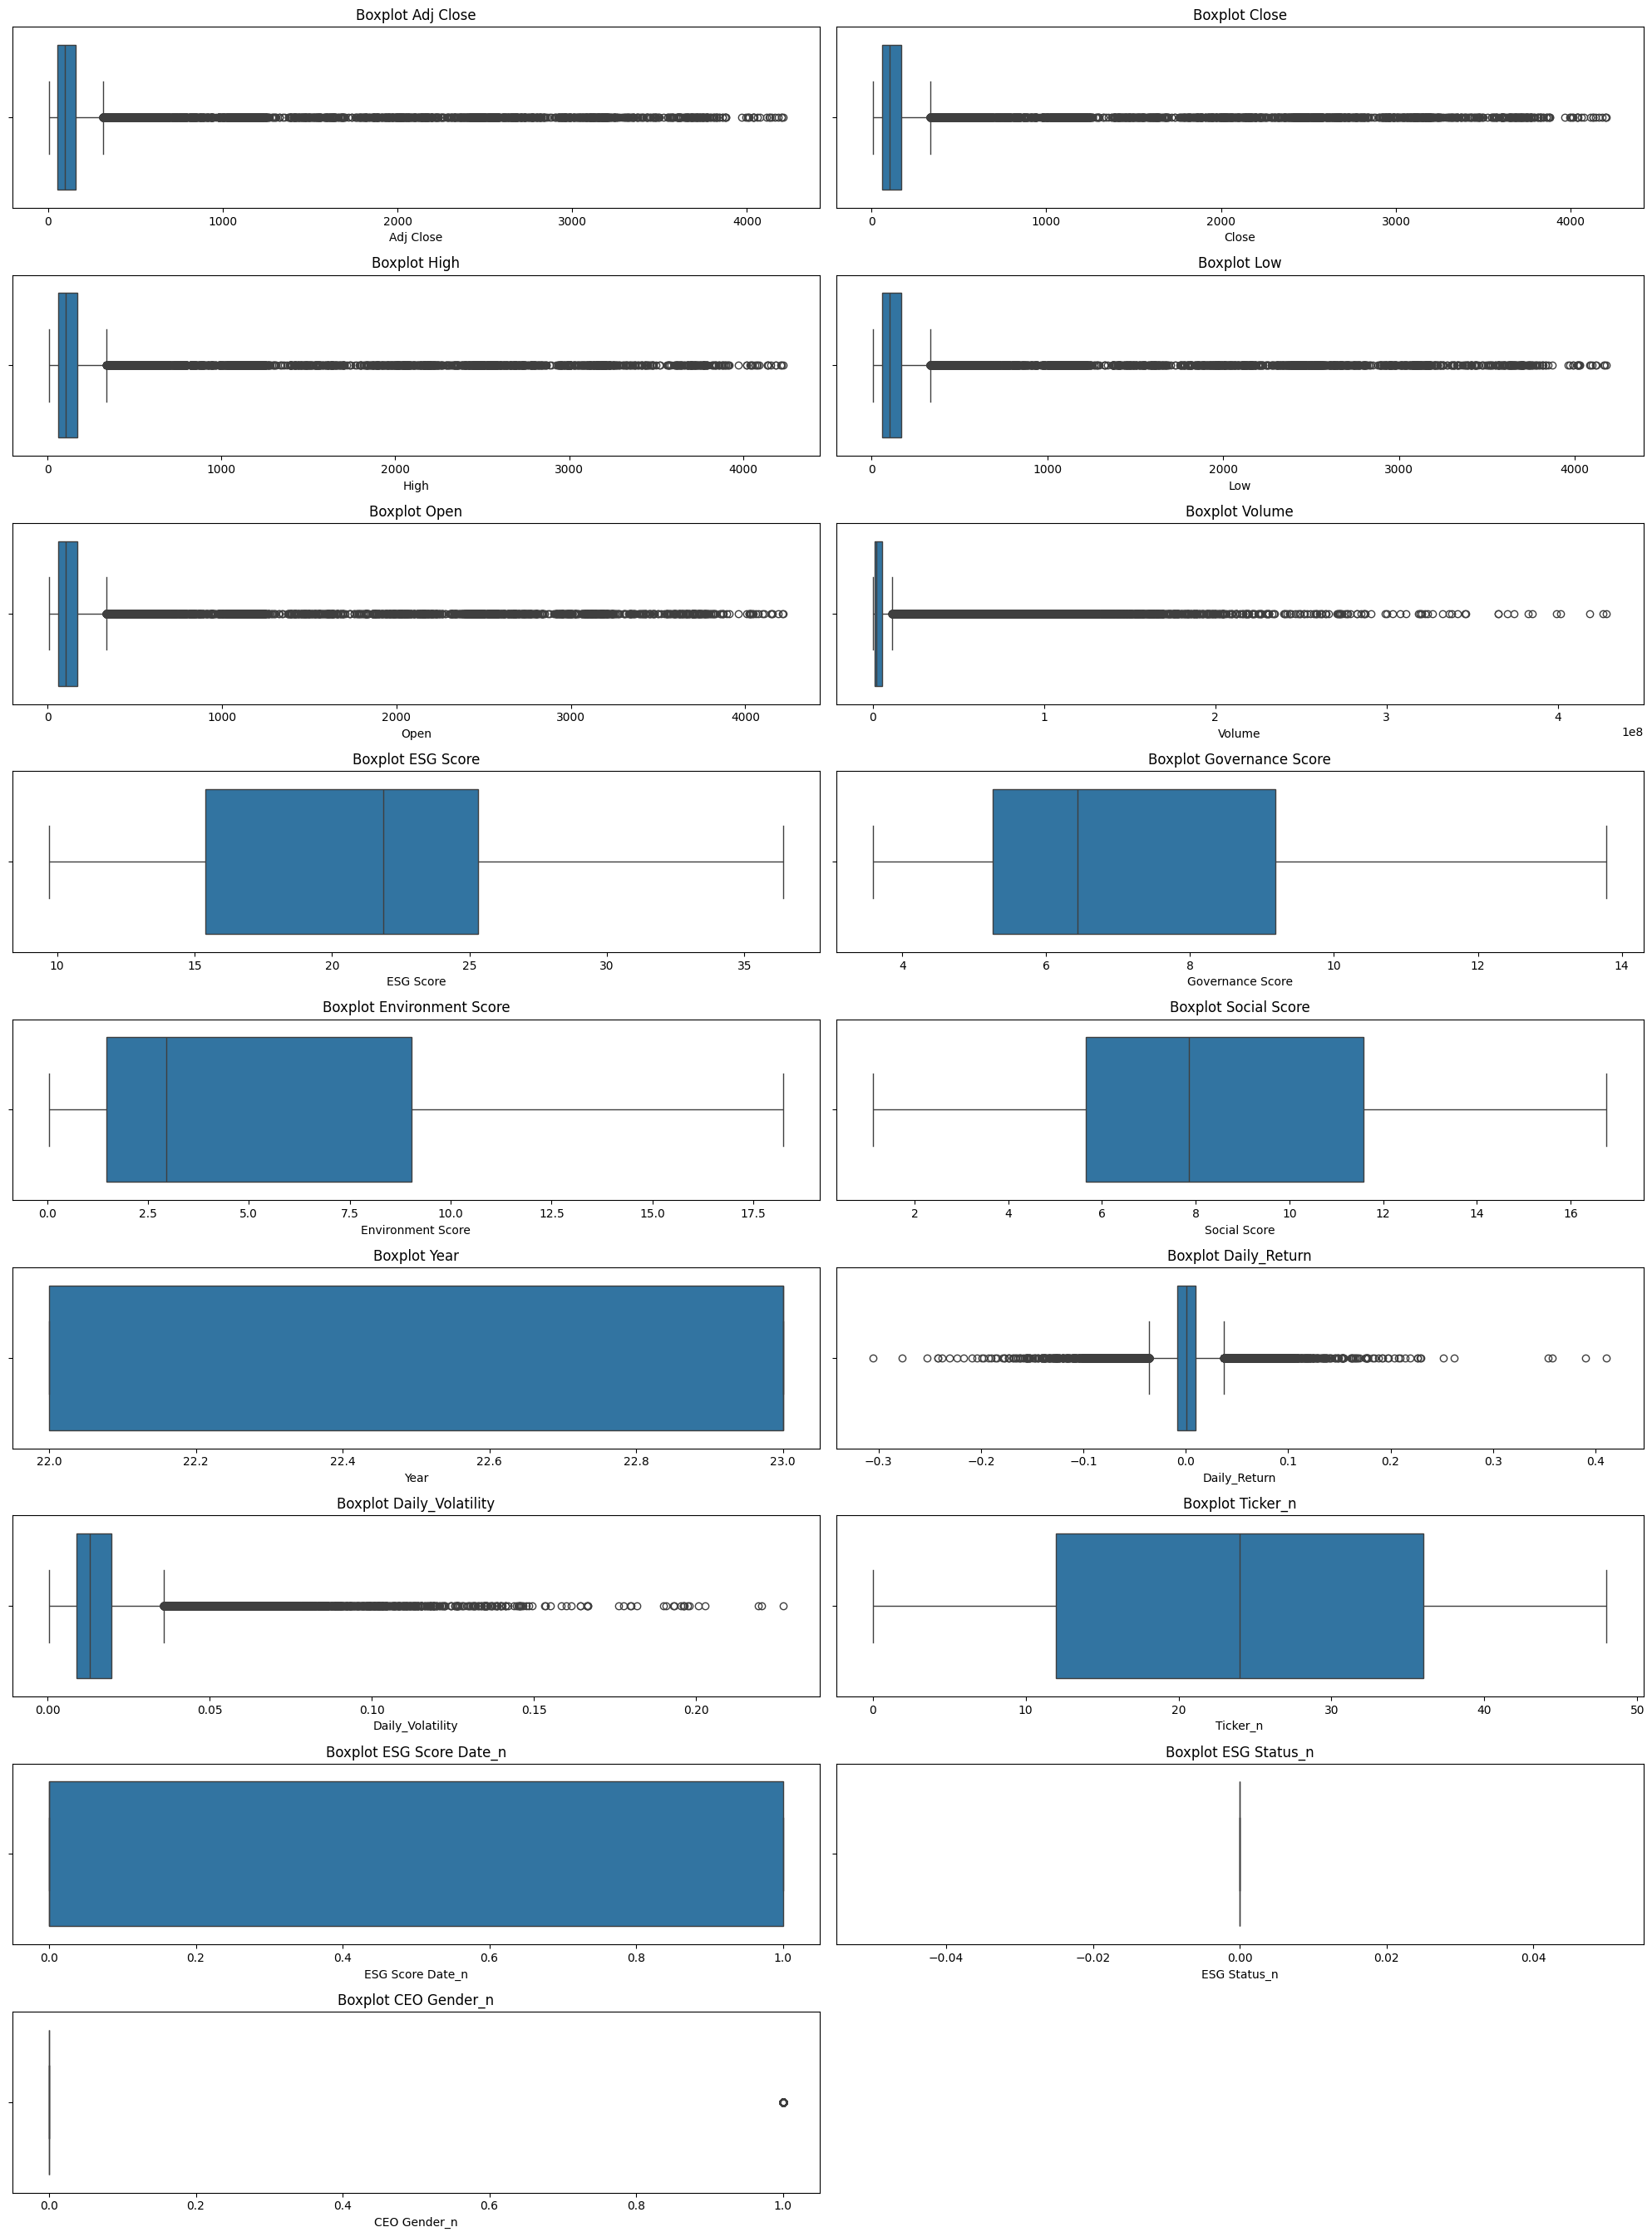

In [31]:
numerical_variables = dataset_final.select_dtypes(include='number').columns
num_vars = len(numerical_variables)# Definir grid
ncols = 2
nrows = num_vars // ncols + (num_vars % ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, nrows * 3)
)

axes = axes.flatten()# Solo boxplots
for i, var in enumerate(numerical_variables):
    sns.boxplot(data=dataset_final, x=var, ax=axes[i])
    axes[i].set_title(f"Boxplot {var}") # Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

Eliminar factorizados

In [32]:
numerical_columns = [
   'Adj Close', 
   'Close', 
   'High', 
   'Low', 
   'Open', 
   'Volume', 
   'ESG Score',
   'Governance Score', 
   'Environment Score', 
   'Social Score', 
   'Year',
   'Daily_Return'
]

for column in numerical_columns:
    stats = dataset_final[column].describe()
    iqr = stats["75%"] - stats["25%"]
    upper_limit = stats["75%"] + 1.5 * iqr
    lower_limit = stats["25%"] - 1.5 * iqr
    if lower_limit < 0:
      lower_limit = 0
    
    outliers = dataset_final[(dataset_final[column] < lower_limit) | (dataset_final[column] > upper_limit)]
    outlier_count = outliers.shape[0]

    print(f"{column.capitalize()} — IQR: {round(iqr, 2)}, Upper limits: {round(upper_limit, 2)}, Lowerlimits: {round(lower_limit, 2)}")
    print(f"Total de outliers: {outlier_count}\n")

Adj close — IQR: 104.89, Upper limits: 316.39, Lowerlimits: 0
Total de outliers: 4492

Close — IQR: 111.07, Upper limits: 336.49, Lowerlimits: 0
Total de outliers: 4109

High — IQR: 112.12, Upper limits: 339.74, Lowerlimits: 0
Total de outliers: 4105

Low — IQR: 110.0, Upper limits: 333.17, Lowerlimits: 0
Total de outliers: 4101

Open — IQR: 111.03, Upper limits: 336.38, Lowerlimits: 0
Total de outliers: 4105

Volume — IQR: 4156800.0, Upper limits: 11489700.0, Lowerlimits: 0
Total de outliers: 13150

Esg score — IQR: 9.94, Upper limits: 40.23, Lowerlimits: 0.47
Total de outliers: 0

Governance score — IQR: 3.92, Upper limits: 15.06, Lowerlimits: 0
Total de outliers: 0

Environment score — IQR: 7.57, Upper limits: 20.39, Lowerlimits: 0
Total de outliers: 0

Social score — IQR: 5.93, Upper limits: 20.48, Lowerlimits: 0
Total de outliers: 0

Year — IQR: 1.0, Upper limits: 24.5, Lowerlimits: 20.5
Total de outliers: 0

Daily_return — IQR: 0.02, Upper limits: 0.04, Lowerlimits: 0
Total de ou

In [33]:
dataset_final.isnull().sum().sort_values(ascending=False) / len(dataset_final)

Date                 0.0
Ticker               0.0
ESG Status_n         0.0
ESG Score Date_n     0.0
Ticker_n             0.0
Daily_Volatility     0.0
Daily_Return         0.0
Year                 0.0
CEO Gender           0.0
ESG Status           0.0
ESG Score Date       0.0
Social Score         0.0
Environment Score    0.0
Governance Score     0.0
ESG Score            0.0
Volume               0.0
Open                 0.0
Low                  0.0
High                 0.0
Close                0.0
Adj Close            0.0
CEO Gender_n         0.0
dtype: float64

# SPLIT TRAIN/TEST #

In [34]:
from sklearn.model_selection import train_test_split


num_variables = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ESG Score','Governance Score', 'Environment Score', 'Social Score', 'Year', 'Daily_Return', 'Ticker_n', 'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n']

X = dataset_final.drop("Daily_Volatility", axis = 1)[num_variables]
y = dataset_final["Daily_Volatility"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

Adj Close        Close         High          Low         Open  \
78362  2502.050049  2502.050049  2513.870117  2495.000000  2502.419922   
56803    23.245001    23.245001    23.497499    22.903749    23.049376   
43012   100.127922   107.529999   108.529999   106.650002   107.000000   
31635    42.128437    46.660000    47.040001    46.240002    46.700001   
67138   110.852661   117.290001   120.080002   117.139999   118.930000   

          Volume  ESG Score  Governance Score  Environment Score  \
78362   120700.0      11.04              3.83               0.11   
56803  9395200.0      16.40              7.11               0.40   
43012   635500.0      23.72              6.43              12.75   
31635  3753100.0      25.32             13.79               1.87   
67138  1181400.0      13.85              6.27               3.91   

       Social Score  Year  Daily_Return  Ticker_n  ESG Score Date_n  \
78362          7.09    23     -0.003779        40                 0   
56803          8.88    23      0.021422        29                 0   
43012          4.54    23      0.006364        22                 0   
31635          9.67    22     -0.001925        16                 1   
67138          3.66    23     -0.014535        34                 0   

       ESG Status_n  CEO Gender_n  
78362             0             0  
56803             0             1  
43012             0             0  
31635             0             0  
67138             0             0

## NORMALIZACION ##

In [35]:
from sklearn.preprocessing import StandardScaler
import pickle

normalizador= StandardScaler()
normalizador.fit(X_train)

X_train_norm = normalizador.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = num_variables)

X_test_norm = normalizador.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = num_variables)

X_train_norm.head()

Adj Close     Close      High       Low      Open    Volume  ESG Score  \
78362   7.856194  7.842535  7.805124  7.910901  7.852324 -0.410084  -1.390203   
56803  -0.432184 -0.456834 -0.457411 -0.456914 -0.457818 -0.002128  -0.635564   
43012  -0.175110 -0.174636 -0.175291 -0.173441 -0.176440 -0.387440   0.395025   
31635  -0.369043 -0.378437 -0.379302 -0.377923 -0.378548 -0.250306   0.620290   
67138  -0.139250 -0.141958 -0.136971 -0.137933 -0.136454 -0.363427  -0.994581   

       Governance Score  Environment Score  Social Score      Year  \
78362         -1.290974          -1.024962     -0.333203  0.980158   
56803         -0.016994          -0.968523      0.127671  0.980158   
43012         -0.281111           1.434990     -0.989755  0.980158   
31635          2.577577          -0.682437      0.331074 -1.020244   
67138         -0.343257          -0.285420     -1.216329  0.980158   

       Daily_Return  Ticker_n  ESG Score Date_n  ESG Status_n  CEO Gender_n  
78362     -0.217801  1.129082         -0.980158           0.0     -0.373156  
56803      1.020843  0.353031         -0.980158           0.0      2.679842  
43012      0.280734 -0.140820         -0.980158           0.0     -0.373156  
31635     -0.126703 -0.564121          1.020244           0.0     -0.373156  
67138     -0.746526  0.705781         -0.980158           0.0     -0.373156

## MIN MAX SCALER ##

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index = X_train.index, columns = num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index = X_test.index, columns = num_variables)

X_train_scal.head()

Adj Close     Close      High       Low      Open    Volume  ESG Score  \
78362   0.594306  0.594245  0.593583  0.595943  0.592813  0.000194   0.049831   
56803   0.003921  0.003771  0.003699  0.003936  0.003664  0.021834   0.250656   
43012   0.022233  0.023849  0.023840  0.023991  0.023612  0.001395   0.524916   
31635   0.008419  0.009349  0.009275  0.009525  0.009284  0.008670   0.584863   
67138   0.024787  0.026174  0.026576  0.026503  0.026447  0.002669   0.155114   

       Governance Score  Environment Score  Social Score  Year  Daily_Return  \
78362          0.023529           0.003300      0.381865   1.0      0.421144   
56803          0.345098           0.019252      0.496169   1.0      0.456315   
43012          0.278431           0.698570      0.219029   1.0      0.435300   
31635          1.000000           0.100110      0.546616   0.0      0.423730   
67138          0.262745           0.212321      0.162835   1.0      0.406131   

       Ticker_n  ESG Score Date_n  ESG Status_n  CEO Gender_n  
78362  0.833333               0.0           0.0           0.0  
56803  0.604167               0.0           0.0           1.0  
43012  0.458333               0.0           0.0           0.0  
31635  0.333333               1.0           0.0           0.0  
67138  0.708333               0.0           0.0           0.0

In [37]:
dataframes = {
    "X_train": X_train,
    "X_train_norm": X_train_norm,
    "X_train_scal": X_train_scal,
    "X_test": X_test,
    "X_test_norm": X_test_norm,
    "X_test_scal": X_test_scal,
    "y_train": y_train,
    "y_test": y_test,
    }

# Base path to save the files
save_path = "../data/processed/"

# Save the DataFrames in CSV
for name, df in dataframes.items():
    df.to_csv(f"{save_path}{name}.csv", index=False)

In [38]:
# Save the scaler and normalizer models
models = {
    "normalizer": normalizador,
    "scaler": scaler,
     
} 

save_path = "../models/"

for name, df in models.items():
    with open(f"{save_path}{name}.pkl", "wb") as file:
        pickle.dump(df, file)

# MODELO REGRESION LINEAL MULTIPLE #

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
]:
    model = LinearRegression()
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)
    
    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

R2 scores: [0.13474119901599302, 0.13474119901599502, 0.13474119901599402]
Best R2: 0.13474119901599502
MSE: [0.00013627836760394862, 0.00013627836760394832, 0.00013627836760394846]
Best MSE: 0.00013627836760394832


In [40]:
model = LinearRegression()
model.fit(X_train_norm, y_train)

y_pred_test = model.predict(X_test_norm)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"El R2 en test del modelo de regresión lineal es de {r2_test} y el MSE en test es {mse_test}")

El R2 en test del modelo de regresión lineal es de 0.14452771040527934 y el MSE en test es 0.00013924201165492893


In [41]:
import pickle
from pickle import dump

with open("linear_regression_model.pkl", "wb") as f:
    pickle.dump(model, f)

# RANDOM FOREST #

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
]:
    model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
    
    model = RandomForestRegressor()
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)

    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

R2 scores: [0.9224948600570874, 0.9221848098012563, 0.9224398066372039]
Best R2: 0.9224948600570874
MSE: [1.2207069076123692e-05, 1.2255902029561195e-05, 1.22157399965283e-05]
Best MSE: 1.2207069076123692e-05


In [43]:
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_norm, y_train)
y_pred_test = model.predict(X_test_norm)

y_pred_test = model.predict(X_test_norm)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"El R2 en test del modelo de regresión lineal es de {r2_test} y el MSE en test es {mse_test}")

El R2 en test del modelo de regresión lineal es de 0.457538581219076 y el MSE en test es 8.829440779668808e-05


In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_norm, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_norm)
print("R2 on test set:", r2_score(y_test, y_pred))


Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 3.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 3.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 3.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time= 5.3min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2

RANDOM FOREST W GRID SEARCH

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
]:
    model = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
    
    model = RandomForestRegressor()
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)

    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))


R2 scores: [0.922728831584698, 0.922894485349953, 0.922475069349656]
Best R2: 0.922894485349953
MSE: [1.2170218531740535e-05, 1.214412804333321e-05, 1.2210186114978906e-05]
Best MSE: 1.214412804333321e-05


In [46]:
 model = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_norm, y_train)
y_pred_test = model.predict(X_test_norm)

y_pred_test = model.predict(X_test_norm)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"El R2 en test del modelo de random forest aplicando GridSearch es de {r2_test} y el MSE en test es {mse_test}")

El R2 en test del modelo de random forest aplicando GridSearch es de 0.5136180736710771 y el MSE en test es 7.916655942967273e-05


# XBOOST #

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
]:
    model = XGBRegressor(
    n_estimators=500,        # número de árboles (boosting rounds)
    learning_rate=0.05,      # paso de aprendizaje, bajo para más estabilidad
    max_depth=6,             # profundidad máxima de los árboles
    subsample=0.8,           # fracción de filas que se usan en cada árbol (regulariza)
    colsample_bytree=0.8,    # fracción de columnas por árbol (regulariza)
    min_child_weight=5,      # controla el mínimo peso de nodo, reduce overfitting
    gamma=0,                 # regularización por complejidad, puedes probar 0-5
    reg_alpha=0.1,           # L1 regularización
    reg_lambda=1,            # L2 regularización
    random_state=42,
    n_jobs=-1
)
    
    model = XGBRegressor()
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)

    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

In [ ]:
model = XGBRegressor(
    n_estimators=500,        # número de árboles (boosting rounds)
    learning_rate=0.05,      # paso de aprendizaje, bajo para más estabilidad
    max_depth=6,             # profundidad máxima de los árboles
    subsample=0.8,           # fracción de filas que se usan en cada árbol (regulariza)
    colsample_bytree=0.8,    # fracción de columnas por árbol (regulariza)
    min_child_weight=5,      # controla el mínimo peso de nodo, reduce overfitting
    gamma=0,                 # regularización por complejidad, puedes probar 0-5
    reg_alpha=0.1,           # L1 regularización
    reg_lambda=1,            # L2 regularización
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_norm, y_train)
y_pred_test = model.predict(X_test_norm)

accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy en test:", accuracy)

# K MEANS #